# Notebook
## Do 5’ regions of human protein-coding genes contain the blueprints for alternative splicing?

NB : all variables & filters using the word CDS are corresponding to the TER concept in the paper

In [120]:
# General imports
import os
import sys
import pandas as pd
import scipy
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from tqdm import tqdm
sys.path.append('../')
# Other imports
tqdm.pandas()
import yaml
import json

# Figures imports
import matplotlib
from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string

## YAML FILES CONFIG
yaml = yaml.load(open("config/config_files.yaml"), Loader=yaml.FullLoader)
base_dir = yaml['base_directory']
sys.exit('EXIT : Need to specify the base_directory in config file : "conf_files.yaml"') if base_dir == 'TO_CHANGE' else None
    


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

pvalues_cutoff = json.load(open('config/config_files.json'))['pvalues_cutoff']
pvalues_cutoff = [[e, str(e)] for e in pvalues_cutoff]

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# Define Miso & Siso

In [4]:
refseq_genes = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_pc_genes"])
refseq_genes['Gene_length'] = refseq_genes['End'] - refseq_genes['Start']
refseq_genes['Gene'] = refseq_genes['Attributes'].apply(lambda r: [e.replace('ID=gene-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_genes


refseq_mrna = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_mrnas"])
refseq_mrna['Gene'] = refseq_mrna['Attributes'].apply(lambda r: [e.replace('Parent=gene-', '') for e in r.split(';') if 'Parent' in e][0])
refseq_mrna = pd.merge(refseq_genes[['Gene']], refseq_mrna, on='Gene')
refseq_mrna['NM'] = refseq_mrna['Attributes'].apply(lambda r: [e.replace('ID=rna-', '') for e in r.split(';') if 'ID=' in e][0])

miso_siso = refseq_mrna.groupby('Gene')['NM'].nunique().reset_index()
miso_siso.loc[miso_siso['NM'] > 1, 'Miso_siso'] = 'Miso'
miso_siso.loc[miso_siso['NM'] == 1, 'Miso_siso'] = 'Siso'
miso_siso

,Gene,NM,Miso_siso
0,A1BG,1,Siso
1,A1CF,8,Miso
2,A2M,4,Miso
3,A2ML1,2,Miso
4,A3GALT2,1,Siso
...,...,...,...
19280,ZYG11A,2,Miso
19281,ZYG11B,1,Siso
19282,ZYX,3,Miso
19283,ZZEF1,1,Siso


# Characterize single TER genes

### Load RefSeq TER

In [5]:
refseq_cds = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start']
refseq_cds = refseq_cds.loc[refseq_cds['Length'] > 0] 
refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds['NP'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('ID=cds-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_cds['NM'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent=' in e][0])
refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] = refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] + '-2'
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds[['Start', 'End']] = refseq_cds[['Start', 'End']].astype(int)
refseq_cds['ranges'] = refseq_cds['Start'].astype(str) + '-' + refseq_cds['End'].astype(str)
refseq_cds.head()

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,NM,Miso_siso,ranges
0,NC_000001.11,BestRefSeq,CDS,65565,65573,.,+,0,ID=cds-NP_001005484.2;Parent=rna-NM_001005484....,8,OR4F5,NP_001005484.2,NM_001005484.2,Siso,65565-65573
1,NC_000001.11,BestRefSeq,CDS,69037,70008,.,+,0,ID=cds-NP_001005484.2;Parent=rna-NM_001005484....,971,OR4F5,NP_001005484.2,NM_001005484.2,Siso,69037-70008
2,NC_000001.11,BestRefSeq,CDS,450740,451678,.,-,0,ID=cds-NP_001005221.2;Parent=rna-NM_001005221....,938,OR4F29,NP_001005221.2,NM_001005221.2,Siso,450740-451678
3,NC_000001.11,BestRefSeq,CDS,685716,686654,.,-,0,ID=cds-NP_001005277.1;Parent=rna-NM_001005277....,938,OR4F16,NP_001005277.1,NM_001005277.1,Siso,685716-686654
4,NC_000001.11,BestRefSeq,CDS,924432,924948,.,+,0,ID=cds-NP_001372569.1;Parent=rna-NM_001385640....,516,SAMD11,NP_001372569.1,NM_001385640.1,Miso,924432-924948


### Load RefSeq Exons

In [6]:
refseq_exons_utr = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_exons"])
refseq_exons_utr['RNA_name'] = refseq_exons_utr['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent' in e][0])
refseq_exons_utr['Exon_nb'] = refseq_exons_utr['Attributes'].apply(lambda r: int([e.replace('ID=exon-', '') for e in r.split(';') if 'ID' in e][0].split('-')[1]))
refseq_exons_utr['Length'] = refseq_exons_utr['End'] - refseq_exons_utr['Start'] + 1
refseq_exons_utr['Gene'] = refseq_exons_utr['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons_utr['ranges'] = refseq_exons_utr['Start'].astype(str) + '-' + refseq_exons_utr['End'].astype(str)
refseq_exons_utr.loc[refseq_exons_utr['RNA_name'].str.contains('-2'), 'Gene'] = refseq_exons_utr.loc[refseq_exons_utr['RNA_name'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons_utr = pd.merge(refseq_exons_utr, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons_utr.head()

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,RNA_name,Exon_nb,Length,Gene,ranges,Miso_siso
0,NC_000001.11,BestRefSeq,exon,65419,65433,.,+,.,ID=exon-NM_001005484.2-1;Parent=rna-NM_0010054...,NM_001005484.2,1,15,OR4F5,65419-65433,Siso
1,NC_000001.11,BestRefSeq,exon,65520,65573,.,+,.,ID=exon-NM_001005484.2-2;Parent=rna-NM_0010054...,NM_001005484.2,2,54,OR4F5,65520-65573,Siso
2,NC_000001.11,BestRefSeq,exon,69037,71585,.,+,.,ID=exon-NM_001005484.2-3;Parent=rna-NM_0010054...,NM_001005484.2,3,2549,OR4F5,69037-71585,Siso
3,NC_000001.11,BestRefSeq,exon,450740,451678,.,-,.,ID=exon-NM_001005221.2-1;Parent=rna-NM_0010052...,NM_001005221.2,1,939,OR4F29,450740-451678,Siso
4,NC_000001.11,BestRefSeq,exon,685716,686654,.,-,.,ID=exon-NM_001005277.1-1;Parent=rna-NM_0010052...,NM_001005277.1,1,939,OR4F16,685716-686654,Siso


### Retrieve single TER genes

In [178]:
refseq_cds_count = refseq_cds.groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index()
single_cds = refseq_cds_count.loc[refseq_cds_count['ranges'] == 1]
t = refseq_cds.groupby(['Miso_siso', 'Gene'])['ranges'].nunique()
single_cds_genes = t[t == 1].reset_index().Gene.values.tolist()
single_cds_transcripts = single_cds.drop_duplicates().NM.values.tolist()
print('Number of MISOG & SISOG with a single TER')
print(t[t == 1].reset_index()['Miso_siso'].value_counts())

print('\n')

refseq_exons_count = refseq_exons_utr.groupby(['Miso_siso', 'Gene', 'RNA_name'])['ranges'].count().reset_index()
single_exon = refseq_exons_count.drop_duplicates().loc[refseq_exons_count['ranges'] == 1]
single_exon_transcripts = single_exon.drop_duplicates().RNA_name.values.tolist()
t = refseq_exons_utr.groupby(['Miso_siso', 'Gene'])['ranges'].nunique()
single_exon_genes = t[t == 1].reset_index().Gene.values.tolist()
print('Number of MISOG & SISOG with a single exon (UTR + TER)')
print(t[t == 1].reset_index()['Miso_siso'].value_counts())

Number of MISOG & SISOG with a single TER
Siso    1610
Miso     373
Name: Miso_siso, dtype: int64


Number of MISOG & SISOG with a single exon (UTR + TER)
Siso    995
Miso      2
Name: Miso_siso, dtype: int64


# Stats on Gene & transcript isoforms

In [132]:
def describe(df, x):
    d = df.describe()
    d.loc['Sum'] = df.sum()
    return d


pd.options.display.float_format = '{:,.2f}'.format

# Genes length

refseq_genes = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_pc_genes"])
refseq_genes['Gene_length'] = refseq_genes['End'] - refseq_genes['Start'] + 1
refseq_genes['Gene'] = refseq_genes['Attributes'].apply(lambda r: [e.replace('ID=gene-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_genes = pd.merge(refseq_genes, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')

## Filter single CDS genes
refseq_genes = refseq_genes.loc[~refseq_genes['Gene'].isin(single_cds_genes)]

refseq_genes_stats = pd.DataFrame(refseq_genes.groupby('Miso_siso')['Gene_length'].apply(lambda df: describe(df, refseq_genes))).reset_index().pivot(index='level_1', columns='Miso_siso', values='Gene_length')

# MWU p-value
mwu = scipy.stats.mannwhitneyu(
        refseq_genes.loc[refseq_genes['Miso_siso'] == 'Miso']['Gene_length'],
        refseq_genes.loc[refseq_genes['Miso_siso'] == 'Siso']['Gene_length'],
)[1]
mwu = '{:0.3e}'.format(mwu)


refseq_genes_stats.columns = pd.MultiIndex.from_product([['Gene length'], ['M-iso', 'S-iso']])
refseq_genes_stats.index.name = 'Statistics'
refseq_genes_stats.loc['p-value (MWU)'] = mwu
refseq_genes_stats


# transcript isoforms length

refseq_isoform_length = refseq_exons_utr.copy()
refseq_isoform_length = refseq_isoform_length.loc[~refseq_isoform_length['Gene'].isin(single_cds_genes)]
refseq_isoform_length_stats_raw = refseq_isoform_length.groupby(['Miso_siso', 'Gene', 'RNA_name'])['Length'].sum().reset_index()

refseq_isoform_length_stats = pd.DataFrame(refseq_isoform_length_stats_raw.groupby('Miso_siso')['Length'].apply(lambda r: describe(r, refseq_isoform_length_stats_raw)).T).reset_index().pivot(index='level_1', columns='Miso_siso', values='Length')

# MWU p-value
mwu = scipy.stats.mannwhitneyu(
        refseq_isoform_length_stats_raw.loc[refseq_isoform_length_stats_raw['Miso_siso'] == 'Miso']['Length'],
        refseq_isoform_length_stats_raw.loc[refseq_isoform_length_stats_raw['Miso_siso'] == 'Siso']['Length'],
)[1]
mwu = '{:0.3e}'.format(mwu)

refseq_isoform_length_stats.loc['p-value (MWU)'] = mwu
refseq_isoform_length_stats.columns = pd.MultiIndex.from_product([['Isoforms length'], ['M-iso', 'S-iso']])
refseq_isoform_length_stats.index.name = 'Statistics'


# isoform nb / MISOG

refseq_mrna = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_mrnas"])
refseq_mrna['RNA_length'] = refseq_mrna['End'] - refseq_mrna['Start'] + 1
refseq_mrna['RNA_name'] = refseq_mrna['Attributes'].apply(lambda r: [e.replace('Name=', '') for e in r.split(';') if 'Name' in e][0])
refseq_mrna['Gene'] = refseq_mrna['Attributes'].apply(lambda r: [e.replace('Parent=gene-', '') for e in r.split(';') if 'Parent' in e][0])
refseq_mrna = pd.merge(refseq_mrna, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')

## Filter single CDS genes
refseq_mrna = refseq_mrna.loc[~refseq_mrna['Gene'].isin(single_cds_genes)]

refseq_mrna_stats_raw = refseq_mrna.groupby(['Miso_siso', 'Gene'])['RNA_name'].count().reset_index()
refseq_mrna_stats = pd.DataFrame(refseq_mrna_stats_raw.groupby('Miso_siso')['RNA_name'].apply(lambda r: describe(r, refseq_mrna_stats_raw))).reset_index().pivot(index='level_1', columns='Miso_siso', values='RNA_name')

# MWU p-value
mwu = scipy.stats.mannwhitneyu(
        refseq_mrna_stats_raw.loc[refseq_mrna_stats_raw['Miso_siso'] == 'Miso']['RNA_name'],
        refseq_mrna_stats_raw.loc[refseq_mrna_stats_raw['Miso_siso'] == 'Siso']['RNA_name'],
)[1]
mwu = '{:0.3e}'.format(mwu)

refseq_mrna_stats.loc['p-value (MWU)'] = mwu

refseq_mrna_stats.columns = pd.MultiIndex.from_product([['Isoforms distribution'], ['M-iso', 'S-iso']])
refseq_mrna_stats.index.name = 'Statistics'


# concat stats

concat_gene_iso_level = pd.concat([refseq_genes_stats, refseq_mrna_stats, refseq_isoform_length_stats], axis=1)
concat_gene_iso_level.index.name = ""
concat_gene_iso_level = concat_gene_iso_level.T
concat_gene_iso_level = concat_gene_iso_level.rename({'50%' : 'median'}, axis=1)

# Uncomment to export in Excel format

# concat_gene_iso_level.to_excel('/gstock/GeneIso/results/1_stats_gene_iso.xlsx')

# import openpyxl
# workbook=openpyxl.load_workbook('/gstock/GeneIso/results/GeneIso.xlsx')
# l_sheets = workbook.get_sheet_names()
# if 'Table S1' in l_sheets:
#     std=workbook.get_sheet_by_name('Table S1')
#     workbook.remove_sheet(std)

# with pd.ExcelWriter('/gstock/GeneIso/results/GeneIso.xlsx', mode='a', engine='openpyxl') as writer:  
# #     df.to_excel(writer, sheet_name='Sheet_name_3')
#     concat_gene_iso_level.to_excel(writer, sheet_name='Table S1')



concat_gene_iso_level





25%    median       75%            Sum  \
Gene length           M-iso 15,527.00 36,988.00 90,370.00 933,084,569.00   
                      S-iso  8,293.50 20,617.00 51,898.00 321,962,756.00   
Isoforms distribution M-iso      2.00      3.00      5.00      52,983.00   
                      S-iso      1.00      1.00      1.00       6,307.00   
Isoforms length       M-iso  2,143.00  3,341.00  5,057.50 211,946,987.00   
                      S-iso  1,586.50  2,688.00  4,627.00  22,283,817.00   

                                count          max      mean    min  \
Gene length           M-iso 10,995.00 2,473,592.00 84,864.44 675.00   
                      S-iso  6,307.00 2,304,792.00 51,048.48 433.00   
Isoforms distribution M-iso 10,995.00       144.00      4.82   2.00   
                      S-iso  6,307.00         1.00      1.00   1.00   
Isoforms length       M-iso 52,983.00   109,224.00  4,000.28 235.00   
                      S-iso  6,307.00    43,816.00  3,533.19 213.00   

                                   std p-value (MWU)  
Gene length           M-iso 149,982.94    4.425e-164  
                      S-iso 105,313.23    4.425e-164  
Isoforms distribution M-iso       6.01     0.000e+00  
                      S-iso       0.00     0.000e+00  
Isoforms length       M-iso   2,917.15     1.231e-90  
                      S-iso   2,895.17     1.231e-90

# Stats on Exons, TER and Intron

## Length level

In [30]:
def describe_dev(df,col):
    col = col[0]
    d = df[col].describe().T
    d.loc['Sum'] = df[col].sum()
    d['%Diff'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
    return d


def pvalues(df):
    df = df.set_index('Miso_siso')
    mwu = scipy.stats.mannwhitneyu(
        df.loc['Miso'],
        df.loc['Siso'],
    )
    return mwu[1]

# Exons

refseq_exons = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_exons"])
refseq_exons['Length'] = refseq_exons['End'] - refseq_exons['Start'] + 1
refseq_exons = refseq_exons.loc[refseq_exons['Length'] > 0] 
refseq_exons['Gene'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons['NM'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent=' in e][0])
refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] = refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons = pd.merge(refseq_exons, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons[['Start', 'End']] = refseq_exons[['Start', 'End']].astype(int)
refseq_exons['ranges'] = refseq_exons['Start'].astype(str) + '-' + refseq_exons['End'].astype(str)
refseq_exons = refseq_exons.loc[~refseq_exons['Gene'].isin(single_cds_genes)]


# TERs

refseq_cds = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start'] + 1
refseq_cds = refseq_cds.loc[refseq_cds['Length'] > 0] 
refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds['NP'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('ID=cds-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_cds['NM'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent=' in e][0])

refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] = refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] + '-2'
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds[['Start', 'End']] = refseq_cds[['Start', 'End']].astype(int)
refseq_cds['ranges'] = refseq_cds['Start'].astype(str) + '-' + refseq_cds['End'].astype(str)
refseq_cds = refseq_cds.loc[~refseq_cds['Gene'].isin(single_cds_genes)]

## MWU m-values

l_pvalues = [
    pvalues(refseq_exons.drop_duplicates(subset=['Gene', 'Start', 'End'])[['Miso_siso','Length']]),
    pvalues(refseq_cds.drop_duplicates(subset=['Gene', 'Start', 'End'])[['Miso_siso','Length']]),
]
l_pvalues = [sub_e for e in l_pvalues for sub_e in ['{:0.3e}'.format(e), '{:0.3e}'.format(e), '0']]


# Concat stats

stats_exons_length = pd.concat(
    [
        describe_dev(refseq_exons.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso']),['Length']),
        describe_dev(refseq_cds.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso']),['Length']),        
    ], axis=1
)

stats_exons_length.columns = pd.MultiIndex.from_product([['Length'], ['Exons', 'TER',], ['Miso', 'Siso', '%Diff']])
stats_exons_length.index.name = 'Statistics'
stats_exons_length.loc['p-value (MWU)'] = l_pvalues
stats_exons_length

Length                                                   \
                     Exons                                 TER                
                      Miso         Siso     %Diff         Miso         Siso   
Statistics                                                                    
count               165585        65079   60.6975       150276        62728   
mean               344.846      342.412  0.705952      160.068      172.518   
std                888.459      879.738  0.981544      253.946      315.545   
min                      2            3       -50            1            1   
25%                     93           96  -3.22581           81           88   
50%                    134          136  -1.49254          119          126   
75%                    203          200   1.47783          166          173   
max                  35596        27303   23.2976        17331        21693   
Sum            5.71014e+07  2.22838e+07    60.975  2.40544e+07  1.08217e+07   
p-value (MWU)    4.004e-08    4.004e-08         0   6.935e-140   6.935e-140   

                        
                        
                 %Diff  
Statistics              
count          58.2581  
mean          -7.77774  
std           -24.2567  
min                  0  
25%           -8.64198  
50%           -5.88235  
75%           -4.21687  
max           -25.1688  
Sum            55.0116  
p-value (MWU)        0

## Distri level

In [31]:
def describe_dev(df):
#     print(df.obj)
    d = df.describe().T
    d.loc['Sum'] = df.sum()
    d['%Diff'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
    return d


# Exons

refseq_exons = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_exons"])
refseq_exons['Length'] = refseq_exons['End'] - refseq_exons['Start'] + 1
refseq_exons = refseq_exons.loc[refseq_exons['Length'] > 0] 
refseq_exons['Gene'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons['NM'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent=' in e][0])
refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] = refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons = pd.merge(refseq_exons, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons[['Start', 'End']] = refseq_exons[['Start', 'End']].astype(int)
refseq_exons['ranges'] = refseq_exons['Start'].astype(str) + '-' + refseq_exons['End'].astype(str)
refseq_exons = refseq_exons.loc[~refseq_exons['Gene'].isin(single_cds_genes)]


# TER

refseq_cds = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start'] + 1
refseq_cds = refseq_cds.loc[refseq_cds['Length'] > 0] 
refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds['NP'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('ID=cds-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_cds['NM'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent=' in e][0])

refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] = refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] + '-2'
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds[['Start', 'End']] = refseq_cds[['Start', 'End']].astype(int)
refseq_cds['ranges'] = refseq_cds['Start'].astype(str) + '-' + refseq_cds['End'].astype(str)
refseq_cds = refseq_cds.loc[~refseq_cds['Gene'].isin(single_cds_genes)]

## MWU m-values

l_pvalues = [
    pvalues(refseq_exons.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso', 'Gene'])['Start'].count().rename('Count').reset_index()[['Miso_siso','Count']]),
    pvalues(refseq_cds.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso', 'Gene'])['Start'].count().rename('Count').reset_index()[['Miso_siso','Count']]),
]
l_pvalues = [sub_e for e in l_pvalues for sub_e in ['{:0.3e}'.format(e), '{:0.3e}'.format(e), '0']]
l_pvalues


# Concat stats

stats_exons_distri = pd.concat(
    [
        describe_dev(refseq_exons.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso', 'Gene'])['Start'].count().rename('Count').groupby('Miso_siso')),
        describe_dev(refseq_cds.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso', 'Gene'])['Start'].count().rename('Count').groupby('Miso_siso')),        
    ], axis=1
)

stats_exons_distri.columns = pd.MultiIndex.from_product([['Distribution'], ['Exons', 'TER',], ['Miso', 'Siso', '%Diff']])
stats_exons_distri.index.name = 'Statistics'
stats_exons_distri.loc['p-value (MWU)'] = l_pvalues

stats_exons_distri

Distribution                                               \
                     Exons                              TER               
                      Miso       Siso     %Diff        Miso        Siso   
Statistics                                                                
count                10995       6307   42.6376       10995        6307   
mean                 15.06    10.3185    31.484     13.6677     9.94577   
std                10.9388    10.8312  0.983789     10.8116     10.7766   
min                      1          2      -100           2           2   
25%                      8          4        50           7           4   
50%                     12          7   41.6667          11           7   
75%                     19         12   36.8421          17          12   
max                    364        172   52.7473         363         172   
Sum                 165585      65079   60.6975      150276       62728   
p-value (MWU)    0.000e+00  0.000e+00         0  1.830e-307  1.830e-307   

                         
                         
                  %Diff  
Statistics               
count           42.6376  
mean            27.2314  
std            0.323369  
min                   0  
25%             42.8571  
50%             36.3636  
75%             29.4118  
max             52.6171  
Sum             58.2581  
p-value (MWU)         0

## Introns

In [149]:
# Fct to compute intron boundaries
def get_introns(df):
    df = pd.DataFrame(df)
    l = list()
    exons = df['ranges'].values[0]
    for j, e in enumerate(exons):
        # Exon 1
        if j == 0:
            l.append(int(e.split("-")[1]) + 1)
            
        # Exon 2 <-> Exon -2
        elif j > 0 and j < len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
            l.append(int(e.split("-")[1]) + 1)
            
        # Exon -1
        elif j == len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
    
    # Final list        
    l = ["{}-{}".format(e, l[j + 1]) for j, e in enumerate(l) if j < len(l) - 1 if j % 2 == 0]
    df['Introns'] = [l]
    return df

In [33]:
# Load & process exons
refseq_exons = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_exons"])
refseq_exons['Length'] = refseq_exons['End'] - refseq_exons['Start'] + 1
refseq_exons = refseq_exons.loc[refseq_exons['Length'] > 0] 
refseq_exons['Gene'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons['NM'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent=' in e][0])
refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] = refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons = pd.merge(refseq_exons, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons[['Start', 'End']] = refseq_exons[['Start', 'End']].astype(int)
refseq_exons['ranges'] = refseq_exons['Start'].astype(str) + '-' + refseq_exons['End'].astype(str)
refseq_exons = refseq_exons.loc[~refseq_exons['Gene'].isin(single_cds_genes)]


# Retrieve introns from exons boundaries
refseq_exons_gb_exons = pd.merge(refseq_exons.sort_values(by=['Gene', 'NM', 'Start']).groupby(['Gene','NM'])['ranges'].apply(list).reset_index(), miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons_introns = refseq_exons_gb_exons.groupby(['Gene', 'NM']).progress_apply(get_introns)
refseq_exons_introns_exploded = refseq_exons_introns.explode('Introns')
refseq_exons_introns_exploded[['Intron_Start', 'Intron_End']] = refseq_exons_introns_exploded.Introns.str.split('-', expand=True)
refseq_exons_introns_exploded = refseq_exons_introns_exploded.dropna(subset=['Intron_Start'])
refseq_exons_introns_exploded[['Intron_Start', 'Intron_End']] = refseq_exons_introns_exploded[['Intron_Start', 'Intron_End']].astype(int)
refseq_exons_introns_exploded['Intron_Length'] = refseq_exons_introns_exploded['Intron_End'] - refseq_exons_introns_exploded['Intron_Start'] + 1
refseq_exons_introns_exploded_clean = refseq_exons_introns_exploded.loc[refseq_exons_introns_exploded['Intron_Length'] >= 26]

def pvalues(df):
    df = df.set_index('Miso_siso')
    mwu = scipy.stats.mannwhitneyu(
        df.loc['Miso'],
        df.loc['Siso'],
    )
    return mwu[1]


def describe_dev(df):
    d = df.describe().T
    d.loc['Sum'] = df.sum()
    d['%Diff'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
    return d

stats_intron_exons_utr = pd.concat(
    [
        describe_dev(refseq_exons_introns_exploded_clean[['Miso_siso', 'Gene', 'Intron_Length', 'Intron_Start', 'Intron_End']].drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length']).groupby(['Miso_siso'])['Intron_Length']),
    ], 
    axis=1
)


## MWU m-values

l_pvalues = [
    pvalues(refseq_exons_introns_exploded_clean[['Miso_siso', 'Gene', 'Intron_Length', 'Intron_Start', 'Intron_End']].drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length'])[['Miso_siso', 'Intron_Length']]),
]
l_pvalues = [sub_e for e in l_pvalues for sub_e in ['{:0.3e}'.format(e), '{:0.3e}'.format(e), '0']]

stats_intron_exons_utr.columns = pd.MultiIndex.from_product([['Length'], ['Introns ',], ['Miso', 'Siso', "%Diff"]])
stats_intron_exons_utr.index.name = 'Statistics'
stats_intron_exons_utr.loc['p-value (MWU)'] = l_pvalues

stats_intron_exons_utr

100%|██████████| 59290/59290 [00:42<00:00, 1385.52it/s]


Length                      
                  Introns                       
                      Miso         Siso    %Diff
Statistics                                      
count               164826        58738  64.3636
mean               8494.89      4788.97  43.6253
std                  26797      16487.5  38.4725
min                     26           37 -42.3077
25%                    638          447  29.9373
50%                   1963       1335.5  31.9664
75%                   5838         3511  39.8595
max            1.16041e+06       740920  36.1502
Sum            1.40018e+09  2.81294e+08  79.9101
p-value (MWU)    0.000e+00    0.000e+00        0

In [150]:
# Load & process exons
refseq_exons = pd.read_parquet(base_dir + yaml["TMP"]["tmp_refseq_exons"])
refseq_exons['Length'] = refseq_exons['End'] - refseq_exons['Start'] + 1
refseq_exons = refseq_exons.loc[refseq_exons['Length'] > 0] 
refseq_exons['Gene'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons['NM'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent=' in e][0])
refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] = refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons = pd.merge(refseq_exons, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons[['Start', 'End']] = refseq_exons[['Start', 'End']].astype(int)
refseq_exons['ranges'] = refseq_exons['Start'].astype(str) + '-' + refseq_exons['End'].astype(str)
refseq_exons = refseq_exons.loc[~refseq_exons['Gene'].isin(single_cds_genes)]


# Retrieve introns from exons boundaries
refseq_exons_gb_exons = pd.merge(refseq_exons.sort_values(by=['Gene', 'NM', 'Start']).groupby(['Gene','NM'])['ranges'].apply(list).reset_index(), miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons_introns = refseq_exons_gb_exons.groupby(['Gene', 'NM']).progress_apply(get_introns)
refseq_exons_introns_exploded = refseq_exons_introns.explode('Introns')
refseq_exons_introns_exploded[['Intron_Start', 'Intron_End']] = refseq_exons_introns_exploded.Introns.str.split('-', expand=True)
refseq_exons_introns_exploded = refseq_exons_introns_exploded.dropna(subset=['Intron_Start'])
refseq_exons_introns_exploded[['Intron_Start', 'Intron_End']] = refseq_exons_introns_exploded[['Intron_Start', 'Intron_End']].astype(int)
refseq_exons_introns_exploded['Intron_Length'] = refseq_exons_introns_exploded['Intron_End'] - refseq_exons_introns_exploded['Intron_Start'] + 1
refseq_exons_introns_exploded_clean = refseq_exons_introns_exploded.loc[refseq_exons_introns_exploded['Intron_Length'] >= 26]
# refseq_exons_utr

def pvalues(df):
    df = df.set_index('Miso_siso')
    mwu = scipy.stats.mannwhitneyu(
        df.loc['Miso'],
        df.loc['Siso'],
    )
    return mwu[1]


def describe_dev(df):
    d = df.describe().T
    d.loc['Sum'] = df.sum()
    d['%Diff'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
    return d


## MWU m-values

l_pvalues = [
    pvalues(refseq_exons_introns_exploded_clean[['Miso_siso', 'Gene', 'Intron_Length', 'Intron_Start', 'Intron_End']].drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length']).groupby(['Miso_siso', 'Gene'])['Intron_Start'].count().rename('Count').reset_index()[['Miso_siso','Count']]),
]
l_pvalues = [sub_e for e in l_pvalues for sub_e in ['{:0.3e}'.format(e), '{:0.3e}'.format(e), '0']]
l_pvalues


# Concat stats

stats_intron_exons_utr = pd.concat(
    [
        describe_dev(refseq_exons_introns_exploded_clean[['Miso_siso', 'Gene', 'Intron_Length', 'Intron_Start', 'Intron_End']].drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length']).groupby(['Miso_siso', 'Gene'])['Intron_Start'].count().rename('Count').groupby('Miso_siso')),
    ], axis=1
)

stats_intron_exons_utr.columns = pd.MultiIndex.from_product([['Distribution'], ['Introns ',], ['Miso', 'Siso', "%Diff"]])
stats_intron_exons_utr.index.name = 'Statistics'
stats_intron_exons_utr.loc['p-value (MWU)'] = l_pvalues

stats_intron_exons_utr

100%|██████████| 59290/59290 [00:23<00:00, 2564.91it/s]


Distribution                 
                  Introns                  
                      Miso       Siso %Diff
Statistics                                 
count            10,991.00   6,306.00 42.63
mean                 15.00       9.31 37.89
std                  11.65      10.82  7.13
min                   1.00       1.00  0.00
25%                   7.00       3.00 57.14
50%                  12.00       6.00 50.00
75%                  19.00      11.00 42.11
max                 375.00     170.00 54.67
Sum             164,826.00  58,738.00 64.36
p-value (MWU)    0.000e+00  0.000e+00     0

In [34]:
# Concat all Stats

concat_exon_cds_intron = pd.concat(
    [
        stats_exons_length,
        stats_exons_distri,
        stats_intron_exons_utr,
    ], axis=1
).T.sort_index()

concat_exon_cds_intron = concat_exon_cds_intron.rename({'Miso' : 'M-iso', 'Siso' : 'S-iso'})



## uncomment to export in Excel format

    
# excel_file_path = '/gstock/GeneIso/results/GeneIso.xlsx'
# mode = 'w' if os.path.isfile(excel_file_path) is False else 'a'
# sheet_name = 'Table S2'    

# if mode == 'a':
#     workbook=openpyxl.load_workbook(excel_file_path)
#     l_sheets = workbook.get_sheet_names()
#     if sheet_name in l_sheets:
#         std=workbook.get_sheet_by_name(sheet_name)
#         workbook.remove_sheet(std)

# with pd.ExcelWriter(excel_file_path, mode=mode, engine='openpyxl') as writer:  
# #     df.to_excel(writer, sheet_name='Sheet_name_3')
#     concat_exon_cds_intron.to_excel(writer, sheet_name=sheet_name)
concat_exon_cds_intron

Statistics                     count      mean       std      min      25%  \
Distribution Exons    %Diff  42.6376    31.484  0.983789     -100       50   
                      M-iso    10995     15.06   10.9388        1        8   
                      S-iso     6307   10.3185   10.8312        2        4   
             TER      %Diff  42.6376   27.2314  0.323369        0  42.8571   
                      M-iso    10995   13.6677   10.8116        2        7   
                      S-iso     6307   9.94577   10.7766        2        4   
Length       Exons    %Diff  60.6975  0.705952  0.981544      -50 -3.22581   
                      M-iso   165585   344.846   888.459        2       93   
                      S-iso    65079   342.412   879.738        3       96   
             Introns  %Diff  64.3636   43.6253   38.4725 -42.3077  29.9373   
                      M-iso   164826   8494.89     26797       26      638   
                      S-iso    58738   4788.97   16487.5       37      447   
             TER      %Diff  58.2581  -7.77774  -24.2567        0 -8.64198   
                      M-iso   150276   160.068   253.946        1       81   
                      S-iso    62728   172.518   315.545        1       88   

Statistics                       50%      75%          max          Sum  \
Distribution Exons    %Diff  41.6667  36.8421      52.7473      60.6975   
                      M-iso       12       19          364       165585   
                      S-iso        7       12          172        65079   
             TER      %Diff  36.3636  29.4118      52.6171      58.2581   
                      M-iso       11       17          363       150276   
                      S-iso        7       12          172        62728   
Length       Exons    %Diff -1.49254  1.47783      23.2976       60.975   
                      M-iso      134      203        35596  5.71014e+07   
                      S-iso      136      200        27303  2.22838e+07   
             Introns  %Diff  31.9664  39.8595      36.1502      79.9101   
                      M-iso     1963     5838  1.16041e+06  1.40018e+09   
                      S-iso   1335.5     3511       740920  2.81294e+08   
             TER      %Diff -5.88235 -4.21687     -25.1688      55.0116   
                      M-iso      119      166        17331  2.40544e+07   
                      S-iso      126      173        21693  1.08217e+07   

Statistics                  p-value (MWU)  
Distribution Exons    %Diff             0  
                      M-iso     0.000e+00  
                      S-iso     0.000e+00  
             TER      %Diff             0  
                      M-iso    1.830e-307  
                      S-iso    1.830e-307  
Length       Exons    %Diff             0  
                      M-iso     4.004e-08  
                      S-iso     4.004e-08  
             Introns  %Diff             0  
                      M-iso     0.000e+00  
                      S-iso     0.000e+00  
             TER      %Diff             0  
                      M-iso    6.935e-140  
                      S-iso    6.935e-140

## Retrieve UTRs

In [35]:
# Fct to compute ovelap between 2 intervals
def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

# Fct to retrieve UTR and annotate regions
def get_utrs(df):
    if df.Strand.values[0] == "+":
        strand = "+"
        df = df.sort_values(by=['Start', 'End'])

    elif df.Strand.values[0] == "-":
        strand = "-"
        df = df.sort_values(by=['Start', 'End'], ascending=False)
        
    cds = df.loc[df['Type'] == "CDS", 'ranges'].values.tolist()
    exons = df.loc[df['Type'] == "exon", 'ranges'].values.tolist()
    diff_exons = sorted([int(sub_e) for e in list(set(exons).difference(set(cds))) for sub_e in e.split('-')])
    diff_exons = ["{}-{}".format(diff_exons[i], diff_exons[i+1]) for i, e in enumerate(diff_exons) if i % 2 == 0 and i < len(diff_exons) - 1]

    empty_dict = dict()
    utr_dict = dict()
    shared_five_dict = dict()
    shared_three_dict = dict()
    
    # 1rst loop on exons
    for j, e in enumerate(diff_exons):
        e = [int(sub_e) for sub_e in e.split('-')]
        
        # Nested loop on TERs
        for i, c in enumerate(cds):
            c = [int(sub_c) for sub_c in c.split('-')]
            
            # Check if overlap on coordinates
            if getOverlap(e,c) > 0:
                
                # First occurence
                if i == 0:
                    if strand == "+":
                        new_e = [e[0], c[0] - 1]
                        utr_dict["5_prime"] = c[0] - 1 
                    elif strand == "-":
                        new_e = [c[1] + 1, e[1]]
                        utr_dict["5_prime"] = c[1] + 1 
                    shared_five_dict["-".join([str(sub_e) for sub_e in e])] = True
                    empty_dict["-".join([str(sub_e) for sub_e in e])] = "-".join([str(sub_e) for sub_e in new_e])
                    
                # Last occurence
                elif i == len(cds) - 1:
                    if strand == "+":
                        new_e = [c[1] + 1, e[1]]
                        utr_dict["3_prime"] = c[1] + 1 
                        
                    elif strand == "-":
                        new_e = [e[0], c[0] - 1]  
                        utr_dict["3_prime"] = c[0] - 1 
                    shared_three_dict["-".join([str(sub_e) for sub_e in e])] = True
                    empty_dict["-".join([str(sub_e) for sub_e in e])] = "-".join([str(sub_e) for sub_e in new_e])
                    
        
    df['UTR_ranges'] = df['ranges'].map(empty_dict)
    df['Shared_5_prime'] = df['ranges'].map(shared_five_dict)
    df['Shared_5_prime'] = df['Shared_5_prime'].fillna(False)
    df['Shared_3_prime'] = df['ranges'].map(shared_three_dict)
    df['Shared_3_prime'] = df['Shared_3_prime'].fillna(False)    

    df.loc[df['Type'] == 'CDS', 'Nb_exon'] = list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))
    df.loc[df['Type'] == 'exon', 'Nb_exon'] = list(range(1,df.loc[df['Type'] == 'exon'].shape[0] + 1))
    df.loc[df['Type'] == 'exon', 'Nb_exon_inverted'] = np.array(list(range(1,df.loc[df['Type'] == 'exon'].shape[0] + 1))[::-1]) * -1
    df.loc[df['Type'] == 'CDS', 'Nb_exon_inverted'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))[::-1]) * -1

    if strand == "+":

        if '5_prime' in utr_dict:
            df.loc[df['End'] < utr_dict['5_prime'], 'UTR_ranges'] = df.loc[df['End'] < utr_dict['5_prime']]['ranges']
            df.loc[df['Start'] < utr_dict['5_prime'], 'UTR_bool'] = "5_prime"
            if df.loc[(df['UTR_bool'] == '5_prime') & (df['Shared_5_prime'] == False)].empty is False:
                df.loc[df['Type'] == 'CDS', 'Nb_exon_relative'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))) + df.loc[(df['UTR_bool'] == '5_prime') & (df['Shared_5_prime'] == False)]['Nb_exon'].values[-1] 
            else:
                df.loc[df['Type'] == 'CDS', 'Nb_exon_relative'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))) 

        if '3_prime' in utr_dict:
            df.loc[df['Start'] > utr_dict['3_prime'], 'UTR_ranges'] = df.loc[df['Start'] > utr_dict['3_prime']]['ranges']
            df.loc[df['End'] > utr_dict['3_prime'], 'UTR_bool'] = "3_prime"

    elif strand == "-":

        if '5_prime' in utr_dict:
            df.loc[df['End'] > utr_dict['5_prime'], 'UTR_bool'] = "5_prime"
            df.loc[df['Start'] > utr_dict['5_prime'], 'UTR_ranges'] = df.loc[df['End'] > utr_dict['5_prime']]['ranges']
            if df.loc[(df['UTR_bool'] == '5_prime') & (df['Shared_5_prime'] == False)].empty is False:
                df.loc[df['Type'] == 'CDS', 'Nb_exon_relative'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))) + df.loc[(df['UTR_bool'] == '5_prime') & (df['Shared_5_prime'] == False)]['Nb_exon'].values[-1] 
            else:
                df.loc[df['Type'] == 'CDS', 'Nb_exon_relative'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))) 

        if '3_prime' in utr_dict:
            df.loc[df['End'] < utr_dict['3_prime'], 'UTR_ranges'] = df.loc[df['Start'] < utr_dict['3_prime']]['ranges']
            df.loc[df['Start'] < utr_dict['3_prime'], 'UTR_bool'] = "3_prime"

    return df


def process_introns_utr(df):
    if df.Strand.values[0] == "+":
        strand = "+"
        ascending=True
        reverse=False
        df = df.sort_values(by=['Start', 'End'])

    elif df.Strand.values[0] == "-":
        strand = "-"
        ascending=False
        reverse=True
        df = df.sort_values(by=['Start', 'End'], ascending=ascending)
    df.loc[df['Type'] == 'CDS', 'Nb_exon'] = list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))
    df.loc[df['Type'] == 'exon', 'Nb_exon'] = list(range(1,df.loc[df['Type'] == 'exon'].shape[0] + 1))
    introns_exons = df.loc[df['Type'] == 'exon'].ranges.values.tolist()
    introns_cds = df.loc[df['Type'] == 'CDS'].ranges.values.tolist()
    diff_exons = sorted(set(introns_exons).difference(set(introns_cds)), reverse=reverse)
    if ascending is True:
        first_cds_start = int(introns_cds[0].split('-')[0])
        diff_exons = [e for e in diff_exons if int(e.split('-')[1]) < first_cds_start]
        
    elif ascending is False:
        first_cds_start = int(introns_cds[0].split('-')[1])
        diff_exons = [e for e in diff_exons if int(e.split('-')[0]) > first_cds_start]
    relative_nb = len(diff_exons)

    df.loc[df['Type'] == 'CDS', 'Nb_exon_relative'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))) + relative_nb
    df.loc[df['Type'] == 'exon', 'Nb_exon_inverted'] = np.array(list(range(1,df.loc[df['Type'] == 'exon'].shape[0] + 1))[::-1]) * -1
    df.loc[df['Type'] == 'CDS', 'Nb_exon_inverted'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))[::-1]) * -1

    return df 

In [10]:
concat_cds_exons_path = base_dir + yaml['Final']['misog_sisog_exons_ter']

if os.path.isfile(concat_cds_exons_path) is False:

    concat_cds_exons = pd.concat([
        refseq_cds.reset_index(drop=True),
        refseq_exons.reset_index(drop=True)
    ]).rename({'Region_type' : 'Type'},axis=1)

    concat_cds_exons = concat_cds_exons.loc[~concat_cds_exons["NM"].isin(single_cds_transcripts)]

    concat_cds_exons = concat_cds_exons.sort_values(by=['Gene', 'Start', 'End', 'Type'])
    concat_cds_exons = concat_cds_exons.reset_index(drop=True).groupby(['Gene', 'NM']).progress_apply(get_utrs).reset_index(drop=True)
    concat_cds_exons

    concat_cds_exons = concat_cds_exons.reset_index(drop=True)
    index_wt_relative = concat_cds_exons.loc[concat_cds_exons['Nb_exon_relative'].isna() == True].index.tolist()
    concat_cds_exons.loc[index_wt_relative, 'Nb_exon_relative'] = concat_cds_exons.loc[index_wt_relative, 'Nb_exon'].values.tolist()

    concat_cds_exons.to_parquet(concat_cds_exons_path, index=False)
    concat_cds_exons.to_csv(concat_cds_exons_path.replace('.parquet', '.csv.gz'), index=False, compression='gzip', sep='\t')

else:
    concat_cds_exons = pd.read_parquet(concat_cds_exons_path)    


# Retrieve introns UTRs

In [9]:
concat_introns_path = base_dir + yaml['Final']['misog_sisog_introns']

if os.path.isfile(concat_introns_path) is False:

    refseq_exons_introns_exploded['Type'] = 'exon'
    refseq_exons_introns_exploded = pd.merge(refseq_genes[['Gene', 'Strand']].drop_duplicates(), refseq_exons_introns_exploded, on='Gene')
    refseq_cds_introns_exploded['Type'] = 'CDS'
    refseq_cds_introns_exploded = pd.merge(refseq_genes[['Gene', 'Strand']].drop_duplicates(), refseq_cds_introns_exploded, on='Gene')


    concat_introns = pd.concat(
        [
            refseq_exons_introns_exploded.reset_index(drop=True),
            refseq_cds_introns_exploded.reset_index(drop=True),
        ]
    )

    concat_introns = concat_introns.loc[~concat_introns['NM'].isin(single_cds_transcripts)]


    concat_introns = concat_introns.sort_values(by=['Gene', 'Intron_Start', 'Intron_End', 'Type']).drop(['ranges'], axis=1).rename({'Intron_Start': 'Start', 'Intron_End' : 'End', 'Introns' : 'ranges'}, axis=1)
    concat_introns = concat_introns.reset_index(drop=True).groupby(['Gene', 'NM']).progress_apply(process_introns_utr).reset_index(drop=True)

    concat_introns.to_parquet(concat_introns_path, index=False)
    concat_introns.to_csv(concat_introns_path.replace('.parquet', '.csv.gz'), index=False, compression='gzip', sep='\t')
    
else:
    concat_introns = pd.read_parquet(concat_introns_path)


# Fig S1 fct

In [175]:
plt.rcParams.update({'font.size' : 18})

def custom_boxplot(data, x, y, hue, ax, ylim, title="Title",xlabel="",ylabel="", box_pairs=[()], palette=['grey'], id_string="A", padding_value_boxplot=1, padding_title=10, legend=False, x_legend=0):

    data = data.sort_values(by=hue,ascending=True)
    count = data.groupby([hue, x]).count()['Gene'].reset_index().pivot(columns=[hue],values='Gene',index=x).reset_index()
    count['Miso'] = count['Miso'].apply(lambda r: str(format(int(r), ',')))
    count['Siso'] = count['Siso'].apply(lambda r: str(format(int(r), ',')))
    count['Miso/Siso'] = count[x].astype(str) + '\n(' + count['Miso'] + ' / ' + count['Siso'] + ')'
    
    
    bw = 0.2
    cut = 0
    lw = 1.5

    box = sns.violinplot(data=data, x=x, y=y, hue=hue, showfliers=False, ax=ax, palette=palette, cut=cut, linewidth=lw, bw=bw, scale='width', alpha=0.3)

    plt.setp(box.collections, alpha=.3)

        
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Length (bp)')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xticklabels(count['Miso/Siso'].values.tolist(), fontsize=14)
    
    if not x: 
        ax.spines['bottom'].set_linewidth(0)
        ax.axes.xaxis.set_visible(False)
        
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    
    if legend is True:
    
        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles= 
                  [ 
                    mpatches.Patch([0], [0], color=palette['Miso'], ),
                    mpatches.Patch([0], [0], color=palette['Siso'], ),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
#                     matplotlib.lines.Line2D([0], [0], marker='s', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15)
                    ],  
              labels= ['MISOG', 'SISOG', "Median"], title='', ncol=3, bbox_to_anchor=(0.5,-1), loc='center right')
    else:
        ax.legend().remove()

    means = data.groupby([hue, x])[y].quantile(0.75).reset_index()
    medians = data.groupby([hue, x])[y].quantile(0.5).reset_index()
    for ms, x_shift in zip(['Miso', 'Siso'], [-0.2,0.2]):
        tmp_df_medians = medians.loc[medians['Miso_siso'] == ms]
        tmp_df_means = means.loc[means['Miso_siso'] == ms]
        x_plot = [e + x_shift for e in range(0,5)]
        if 'Introns' in title :
            ax.plot(x_plot, tmp_df_means[y].values, lw=2.5, color=palette[ms],  marker="s", markersize=8, markeredgecolor="black",  markeredgewidth=1, ls='-', )
            ax.plot(x_plot, tmp_df_medians[y].values, lw=2.5, color="white",  marker="o", markersize=6, markeredgecolor="black",  markeredgewidth=1, ls='', )
        else:
            ax.plot(x_plot, tmp_df_medians[y].values, lw=2.5, color=palette[ms],  marker="o", markersize=10, markeredgecolor="black",  markeredgewidth=1, ls='-', )

    add_stat_annotation(ax, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                        test='Mann-Whitney', text_format='simple',  pvalue_thresholds=pvalues_cutoff,
                        loc='outside', fontsize=9, verbose=2, line_height=0.0025, line_offset=0.012)

    return ax

# Fig S1 launch

[((1, 'Miso'), (1, 'Siso')), ((2, 'Miso'), (2, 'Siso')), ((3, 'Miso'), (3, 'Siso')), ((4, 'Miso'), (4, 'Siso')), ((5, 'Miso'), (5, 'Siso')), ((1, 'Miso'), (2, 'Miso')), ((1, 'Miso'), (3, 'Miso')), ((1, 'Miso'), (4, 'Miso')), ((1, 'Miso'), (5, 'Miso')), ((1, 'Siso'), (2, 'Siso')), ((1, 'Siso'), (3, 'Siso')), ((1, 'Siso'), (4, 'Siso')), ((1, 'Siso'), (5, 'Siso'))]
2_Miso v.s. 2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.111e-61 U_stat=1.431e+08
1_Miso v.s. 1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.647e-52 U_stat=1.448e+08
3_Miso v.s. 3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.676e-36 U_stat=1.343e+08
4_Miso v.s. 4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.411e-31 U_stat=1.141e+08
5_Miso v.s. 5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.711e-10 U_stat=9.666e+07
1_Miso v.s. 2_Miso: Mann-Whitney-Wilcoxon tes

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


-4_Miso v.s. -4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.845e-02 U_stat=8.000e+00
-5_Miso v.s. -5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.162e-01 U_stat=2.000e+00
-3_Miso v.s. -3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.005e+02
-2_Miso v.s. -2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.780e+05
-1_Miso v.s. -1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.952e-62 U_stat=1.831e+08
-2_Miso v.s. -1_Miso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.979e+06
-2_Siso v.s. -1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.629e-163 U_stat=2.424e+04
-3_Miso v.s. -1_Miso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.137e-65 U_stat=3.257e+05
-3_Siso v.s. -1_Siso: Mann-Whitney-Wilc

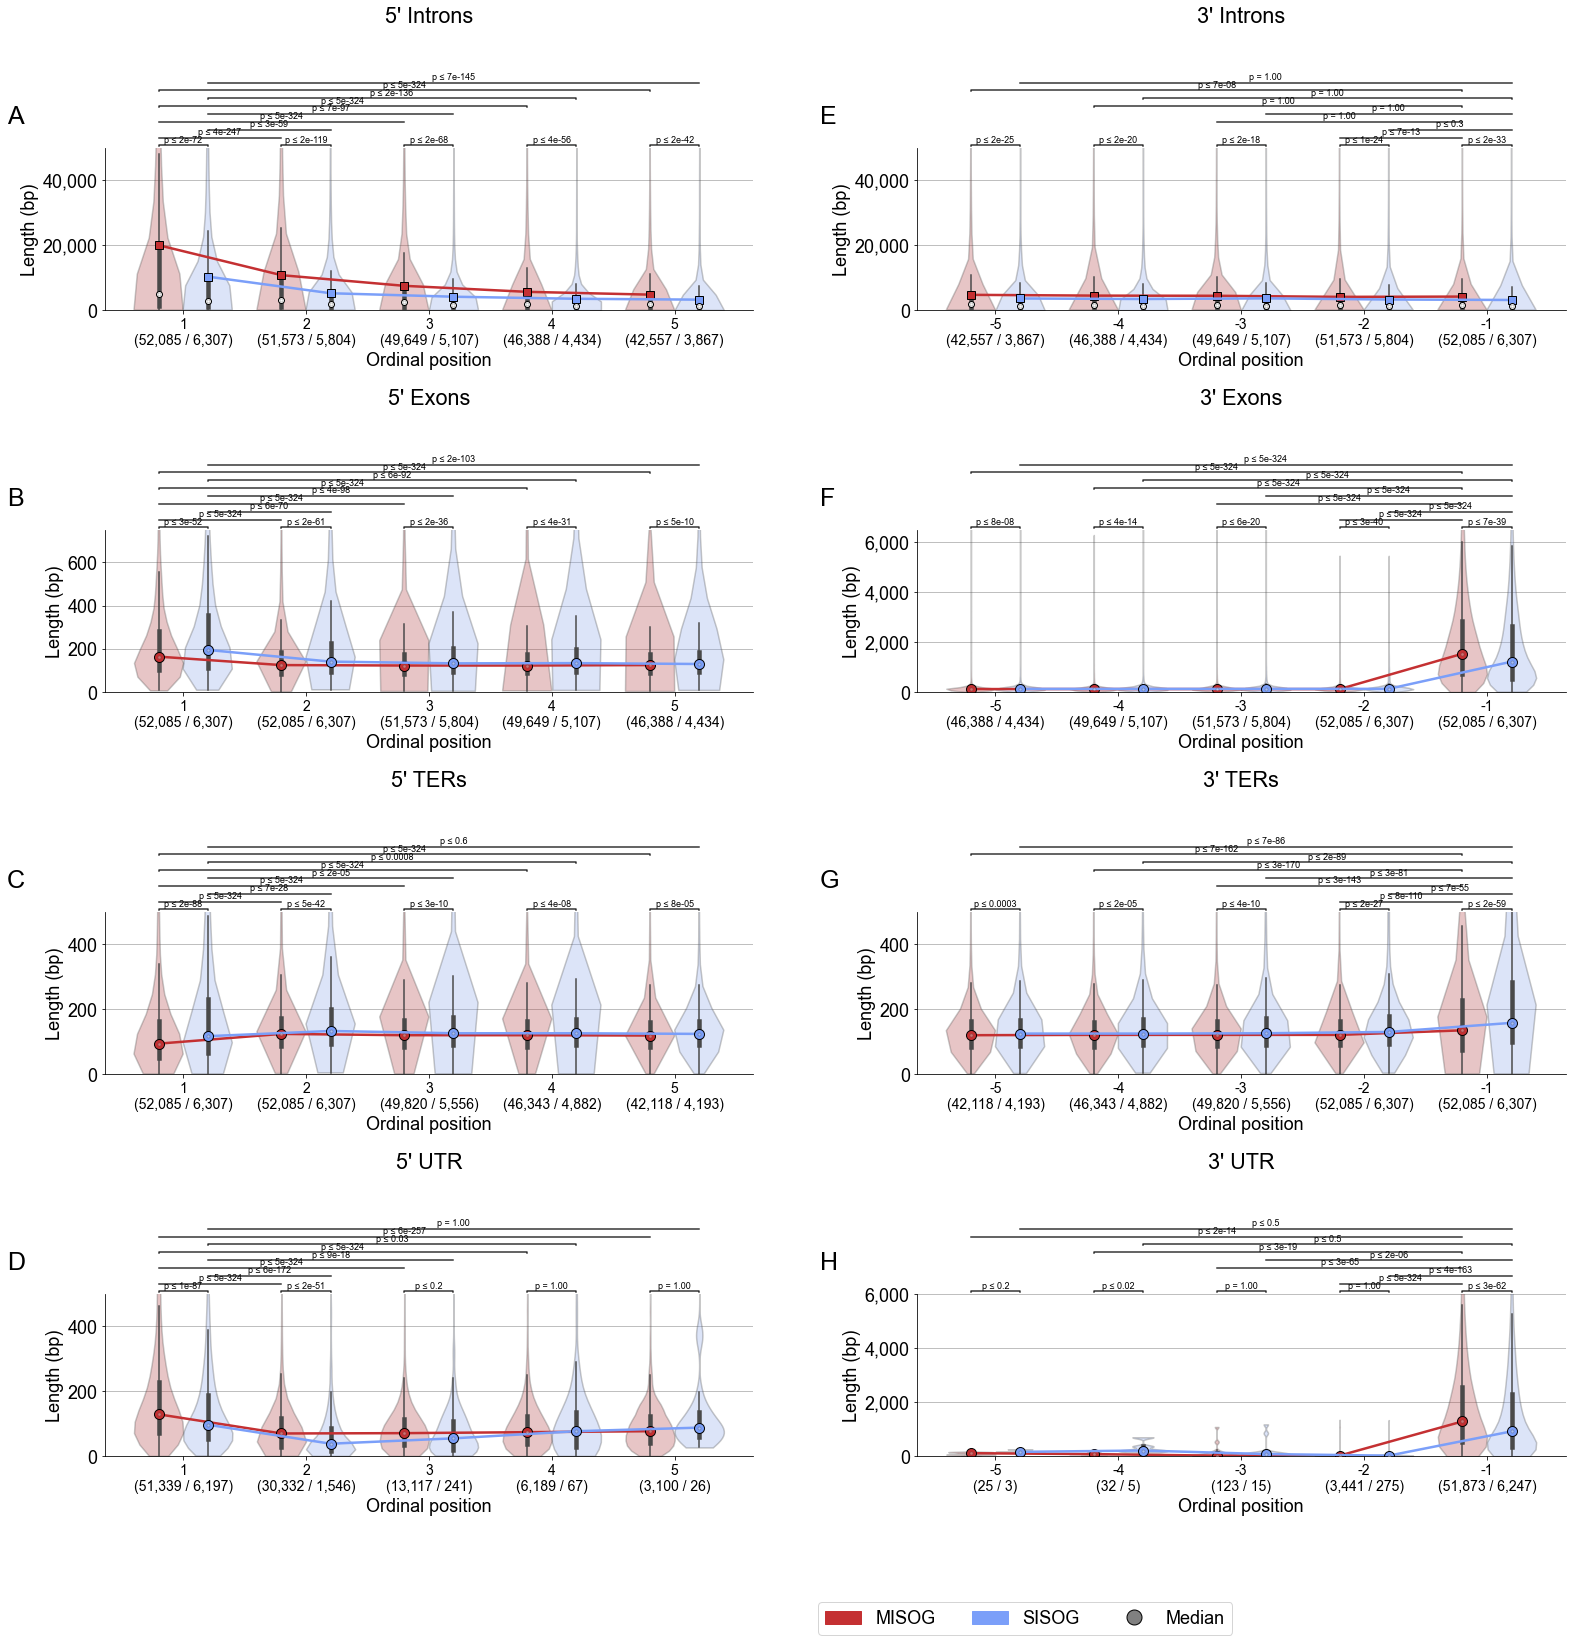

In [176]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(22,25))
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in range(1,6)
]

box_pairs = box_pairs + [((1,'Miso'),(e,'Miso')) for e in range(2,6)] + [((1,'Siso'),(e,'Siso')) for e in range(2,6)]

print(box_pairs)

k_limit = 5
zscore_cutoff = 2
padding_title = 125

# concat_cds_exons['Nb_exon_relative'] = concat_cds_exons['Nb_exon_relative'].fillna(0)
# concat_introns['Nb_exon_relative'] = concat_introns['Nb_exon_relative'].fillna(0)
# concat_cds_exons[['Nb_exon_relative', 'Nb_exon', 'Nb_exon_inverted']] = concat_cds_exons[['Nb_exon_relative', 'Nb_exon', 'Nb_exon_inverted']].astype(int)
# concat_introns[['Nb_exon_relative', 'Nb_exon', 'Nb_exon_inverted']] = concat_introns[['Nb_exon_relative', 'Nb_exon', 'Nb_exon_inverted']].astype(int)

utrs = concat_cds_exons.dropna(subset=['UTR_bool']).reset_index(drop=True)
utrs[['UTR_Start', 'UTR_End']] = utrs.UTR_ranges.str.split('-', expand=True)
utrs[['UTR_Start', 'UTR_End']] = utrs[['UTR_Start', 'UTR_End']].astype(int)
utrs['UTR_Length'] = utrs['UTR_End'] - utrs['UTR_Start']


custom_boxplot(data=concat_cds_exons.loc[(concat_cds_exons['Type'] == 'exon') & (concat_cds_exons['Nb_exon'] <= 5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon', 'Length']].drop_duplicates(), x='Nb_exon', y='Length', hue='Miso_siso', ax=ax[1][0], ylim=(0,750), xlabel='Ordinal position', palette=palette, title="5' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=concat_cds_exons.loc[(concat_cds_exons['Type'] == 'CDS') & (concat_cds_exons['Nb_exon'] <= 5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon', 'Length']].drop_duplicates(), x='Nb_exon', y='Length', hue='Miso_siso', xlabel='Ordinal position', ax=ax[2][0], ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=concat_introns.loc[(concat_introns['Type'] == 'exon') & (concat_introns['Nb_exon'] <= 5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon', 'Intron_Length']].drop_duplicates(), x='Nb_exon', y='Intron_Length', hue='Miso_siso', ax=ax[0][0], xlabel='Ordinal position', ylim=(0,5e4), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' Introns", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=utrs.loc[(utrs['UTR_bool'] == '5_prime') & (utrs['Nb_exon'] <= 5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon', 'UTR_Length']].drop_duplicates(), x='Nb_exon', y='UTR_Length', hue='Miso_siso', ax=ax[3][0], xlabel='Ordinal position', ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' UTR", box_pairs=box_pairs, padding_title=padding_title)


box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in list(range(-5,0))
]
box_pairs = box_pairs + [((-1,'Miso'),(e,'Miso')) for e in range(-5,-1)] + [((-1,'Siso'),(e,'Siso')) for e in range(-5,-1)]

custom_boxplot(data=concat_cds_exons.loc[(concat_cds_exons['Type'] == 'exon')  & (concat_cds_exons['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Length']].drop_duplicates(), x='Nb_exon_inverted', y='Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[1][1], ylim=(0,6.5e3), palette=palette, title="3' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=concat_cds_exons.loc[(concat_cds_exons['Type'] == 'CDS') & (concat_cds_exons['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Length']].drop_duplicates(), x='Nb_exon_inverted', y='Length', hue='Miso_siso', xlabel='Ordinal position',ax=ax[2][1], ylim=(0,500), palette=palette, title="3' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=concat_introns.loc[(concat_introns['Type'] == 'exon') & (concat_introns['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Intron_Length']].drop_duplicates(), x='Nb_exon_inverted', y='Intron_Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[0][1], ylim=(0,50e3), palette=palette, title="3' Introns", box_pairs=box_pairs, padding_title=padding_title, )
custom_boxplot(data=utrs.loc[(utrs['UTR_bool'] == '3_prime') & (utrs['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'UTR_Length']].drop_duplicates(), x='Nb_exon_inverted', y='UTR_Length', hue='Miso_siso',  xlabel='Ordinal position',ax=ax[3][1], ylim=(0,6e3), palette=palette, title="3' UTR", box_pairs=box_pairs, padding_title=padding_title, legend=True, x_legend=1.35,)


i = 0
for n, a in enumerate(ax):
    print(a)
    sub_a = a[0]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1
for n, a in enumerate(ax):
    sub_a = a[1]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1

plt.tight_layout()

figure_path = base_dir + yaml['Figures']['FigS1']
f.savefig(figure_path, dpi=600)

# Raw values

In [71]:
# Concat stats 5' gene elements ordinal 1 to 5
stats_ordinal = pd.concat([
    concat_cds_exons.loc[(concat_cds_exons['Type'] == 'exon') & (concat_cds_exons['Nb_exon'] <= 5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon', 'Length']].drop_duplicates().groupby(['Miso_siso', 'Nb_exon'])['Length'].describe(),
    concat_cds_exons.loc[(concat_cds_exons['Type'] == 'CDS') & (concat_cds_exons['Nb_exon'] <= 5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon', 'Length']].drop_duplicates().groupby(['Miso_siso', 'Nb_exon'])['Length'].describe(),
    concat_introns.loc[(concat_introns['Type'] == 'exon') & (concat_introns['Nb_exon'] <= 5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon', 'Intron_Length']].drop_duplicates().groupby(['Miso_siso', 'Nb_exon'])['Intron_Length'].describe(),
    utrs.loc[(utrs['UTR_bool'] == '5_prime') & (utrs['Nb_exon'] <= 5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon', 'UTR_Length']].drop_duplicates().groupby(['Miso_siso', 'Nb_exon'])['UTR_Length'].describe(),
    
]
).T

stats_ordinal.columns = pd.MultiIndex.from_product([['Ordinal position'], ['Exons', 'TER', 'Introns', "5' UTR"], ['M-iso', "S-iso"], [1,2,3,4,5]])
stats_ordinal = stats_ordinal.T

# Concat stats 3' gene elements ordinal -5 to -1
stats_ordinal_inverted =pd.concat([
    concat_cds_exons.loc[(concat_cds_exons['Type'] == 'exon')  & (concat_cds_exons['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Length']].drop_duplicates().groupby(['Miso_siso', 'Nb_exon_inverted'])['Length'].describe(),
    concat_cds_exons.loc[(concat_cds_exons['Type'] == 'CDS') & (concat_cds_exons['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Length']].drop_duplicates().groupby(['Miso_siso', 'Nb_exon_inverted'])['Length'].describe(),
    concat_introns.loc[(concat_introns['Type'] == 'exon') & (concat_introns['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'Intron_Length']].drop_duplicates().groupby(['Miso_siso', 'Nb_exon_inverted'])['Intron_Length'].describe(),
    utrs.loc[(utrs['UTR_bool'] == '3_prime') & (utrs['Nb_exon_inverted'] >= -5)][['Gene', 'NM', 'Miso_siso', 'Nb_exon_inverted', 'UTR_Length']].drop_duplicates().groupby(['Miso_siso', 'Nb_exon_inverted'])['UTR_Length'].describe(),
    ]).T

stats_ordinal_inverted.columns = pd.MultiIndex.from_product([['Inverted ordinal position'], ['Exons', 'TER', 'Introns',  "3' UTR"], ['M-iso', "S-iso"], [-5,-4,-3,-2,-1]])
stats_ordinal_inverted = stats_ordinal_inverted.T




stats_ordinal_final = pd.concat([stats_ordinal, stats_ordinal_inverted]).rename({'50%' : 'median'}, axis=1)


# Uncomment to export in Excel format

# excel_file_path = '/gstock/GeneIso/results/GeneIso.xlsx'
# mode = 'w' if os.path.isfile(excel_file_path) is False else 'a'
# sheet_name = 'Table S3'    

# if mode == 'a':
#     workbook=openpyxl.load_workbook(excel_file_path)
#     l_sheets = workbook.get_sheet_names()
#     if sheet_name in l_sheets:
#         std=workbook.get_sheet_by_name(sheet_name)
#         workbook.remove_sheet(std)

# with pd.ExcelWriter(excel_file_path, mode=mode, engine='openpyxl') as writer:  
# #     df.to_excel(writer, sheet_name='Sheet_name_3')
#     stats_ordinal_final.to_excel(writer, sheet_name=sheet_name)

stats_ordinal_final

count         mean          std  \
Ordinal position          Exons  M-iso  1  52085.0   237.283633   251.261071   
                                        2  52085.0   194.340635   332.040724   
                                        3  51573.0   224.282881   529.922142   
                                        4  49649.0   271.103829   729.503200   
                                        5  46388.0   302.200138   848.529742   
...                                            ...          ...          ...   
Inverted ordinal position 3' UTR S-iso -5      3.0   192.000000    53.693575   
                                       -4      5.0   323.600000   225.293808   
                                       -3     15.0   195.133333   340.000602   
                                       -2    275.0    33.094545    86.057728   
                                       -1   6247.0  1649.386265  2010.889931   

                                             min    25%  median     75%  \
Ordinal position          Exons  M-iso  1    8.0  100.0   164.0   283.0   
                                        2    2.0   85.0   125.0   184.0   
                                        3    3.0   85.0   123.0   177.0   
                                        4    6.0   87.0   123.0   175.0   
                                        5    3.0   90.0   125.0   174.0   
...                                          ...    ...     ...     ...   
Inverted ordinal position 3' UTR S-iso -5  161.0  161.0   161.0   207.5   
                                       -4  137.0  210.0   210.0   362.0   
                                       -3    3.0   47.5    79.0   105.5   
                                       -2    1.0    9.0    21.0    36.0   
                                       -1    1.0  324.0   918.0  2296.5   

                                               max  
Ordinal position          Exons  M-iso  1   6290.0  
                                        2  13672.0  
                                        3  23264.0  
                                        4  30081.0  
                                        5  24927.0  
...                                            ...  
Inverted ordinal position 3' UTR S-iso -5    254.0  
                                       -4    699.0  
                                       -3   1176.0  
                                       -2   1332.0  
                                       -1  25445.0  

[100 rows x 8 columns]

# Prepare Fig 2 values for distance START  /STOP

In [13]:
# Retrieve TSS ↔ START & STOP ↔ STOP
def get_total_length_utr(df):
    if df.Strand.values[0] == "+":
        strand = "+"
        ascending=True
        reverse=False
        df = df.sort_values(by=['Start', 'End'])
        first_nt_cds = df.loc[df['Type'] == 'CDS'].Start.values[0]
        last_nt_cds = df.loc[df['Type'] == 'CDS'].End.values[-1]
        first_nt_exon = df.loc[df['Type'] == 'exon'].Start.values[0]
        last_nt_exon = df.loc[df['Type'] == 'exon'].End.values[-1]
        complete_five_utr_length = first_nt_cds - first_nt_exon
        complete_three_utr_length = last_nt_exon - last_nt_cds
    elif df.Strand.values[0] == "-":
        strand = "-"
        ascending=False
        reverse=True
        df = df.sort_values(by=['Start', 'End'], ascending=ascending)
        first_nt_cds = df.loc[df['Type'] == 'CDS'].End.values[0]
        last_nt_cds = df.loc[df['Type'] == 'CDS'].Start.values[-1]
        first_nt_exon = df.loc[df['Type'] == 'exon'].End.values[0]
        last_nt_exon = df.loc[df['Type'] == 'exon'].Start.values[-1]
        complete_five_utr_length = first_nt_exon - first_nt_cds
        complete_three_utr_length = last_nt_cds - last_nt_exon

    df['Complete_5_prime_UTR_length'] = complete_five_utr_length
    df['Complete_3_prime_UTR_length'] = complete_three_utr_length
    return df


from pandarallel import pandarallel
pandarallel.initialize(nb_workers=60, progress_bar=True)

concat_cds_exons_first = concat_cds_exons[(concat_cds_exons['Nb_exon'] == 1) | (concat_cds_exons['Nb_exon_inverted'] == -1)]
concat_cds_exons_utr_length = concat_cds_exons_first.groupby(['Gene', 'NM']).parallel_apply(lambda df: get_total_length_utr(df)).drop_duplicates()
concat_cds_exons_utr_length

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,...,ranges,UTR_ranges,Shared_5_prime,Shared_3_prime,Nb_exon,Nb_exon_inverted,UTR_bool,Nb_exon_relative,Complete_5_prime_UTR_length,Complete_3_prime_UTR_length
0,NC_000019.10,BestRefSeq,exon,58353404,58353492,.,-,.,ID=exon-NM_130786.4-1;Parent=rna-NM_130786.4;D...,89,...,58353404-58353492,58353438-58353492,True,False,1.0,-8.0,5_prime,1.0,55,1839
1,NC_000019.10,BestRefSeq,CDS,58353404,58353437,.,-,0,ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...,34,...,58353404-58353437,None,False,False,1.0,-8.0,None,1.0,55,1839
14,NC_000019.10,BestRefSeq,CDS,58347022,58347029,.,-,2,ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...,8,...,58347022-58347029,None,False,False,8.0,-1.0,None,8.0,55,1839
15,NC_000019.10,BestRefSeq,exon,58345183,58347029,.,-,.,ID=exon-NM_130786.4-8;Parent=rna-NM_130786.4;D...,1847,...,58345183-58347029,58345183-58347021,False,True,8.0,-1.0,3_prime,8.0,55,1839
16,NC_000010.11,BestRefSeq,exon,50885581,50885627,.,-,.,ID=exon-NM_001198818.2-1;Parent=rna-NM_0011988...,47,...,50885581-50885627,50885581-50885627,False,False,1.0,-14.0,5_prime,1.0,25687,7320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403971,NC_000001.11,BestRefSeq,exon,77562416,77565784,.,-,.,ID=exon-NM_001376156.1-14;Parent=rna-NM_001376...,3369,...,77562416-77565784,77562416-77565639,False,True,14.0,-1.0,3_prime,14.0,43927,3224
1403972,NC_000001.11,BestRefSeq,exon,77682585,77682658,.,-,.,ID=exon-NM_015534.6-1;Parent=rna-NM_015534.6;D...,74,...,77682585-77682658,77682585-77682658,False,False,1.0,-15.0,5_prime,1.0,49304,3224
1403977,NC_000001.11,BestRefSeq,CDS,77631850,77633354,.,-,0,ID=cds-NP_056349.1;Parent=rna-NM_015534.6;Dbxr...,1505,...,77631850-77633354,None,False,False,1.0,-11.0,None,5.0,49304,3224
1403996,NC_000001.11,BestRefSeq,CDS,77565640,77565784,.,-,1,ID=cds-NP_056349.1;Parent=rna-NM_015534.6;Dbxr...,145,...,77565640-77565784,None,False,False,11.0,-1.0,None,15.0,49304,3224


# Fig 2

                                         count          mean           std  \
Miso_siso variable                                                           
Miso      Complete_3_prime_UTR_length  52085.0   2248.249227   4001.729228   
          Complete_5_prime_UTR_length  52085.0  19124.569511  54099.511747   
Siso      Complete_3_prime_UTR_length   6307.0   1825.381005   3350.255446   
          Complete_5_prime_UTR_length   6307.0   3575.206279  15475.871598   

                                       min    25%     50%      75%        max  
Miso_siso variable                                                             
Miso      Complete_3_prime_UTR_length  0.0  565.0  1388.0   2794.0   238767.0  
          Complete_5_prime_UTR_length  0.0  154.0  1577.0  15054.0  1879159.0  
Siso      Complete_3_prime_UTR_length  0.0  338.5   979.0   2394.0   175522.0  
          Complete_5_prime_UTR_length  0.0   59.0   143.0    638.5   371086.0  
Complete_3_prime_UTR_length_Miso v.s. Complete_3_pr

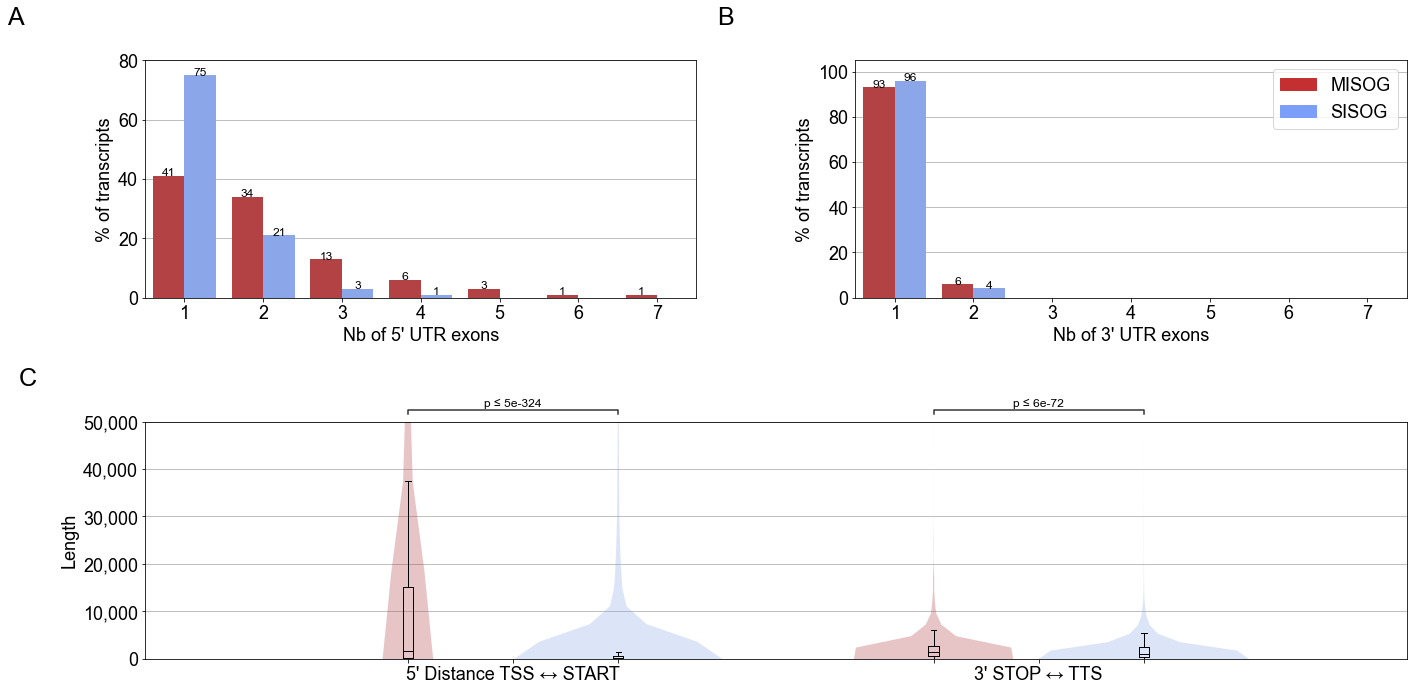

In [126]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            if np.isnan(p.get_height()) == False and p.get_height() > 0.4:
                value = '{:0}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center", fontsize=12) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

fig = plt.figure(figsize=(20, 10)) 
gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[1, 1]) 
ax00 = plt.subplot(gs[0,0])
ax01 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0:])



data_5_prime = 100 * ( concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '5_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index().groupby('Miso_siso')['ranges'].value_counts() / concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '5_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index().groupby('Miso_siso')['ranges'].value_counts().groupby('Miso_siso').sum())
data_5_prime = data_5_prime.rename('count').reset_index()
data_5_prime = data_5_prime.loc[data_5_prime['ranges'] <= 7]
data_5_prime = data_5_prime.round()
data_3_prime = 100 * ( concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '3_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index().groupby('Miso_siso')['ranges'].value_counts() / concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '3_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index().groupby('Miso_siso')['ranges'].value_counts().groupby('Miso_siso').sum())
data_3_prime = data_3_prime.rename('count').reset_index()
data_3_prime = data_3_prime.loc[data_3_prime['ranges'] <= 7]
data_3_prime = data_3_prime.round()
data_length_utr = utrs.groupby(['Miso_siso', 'Gene', 'NM', 'UTR_bool'])['UTR_Length'].sum().sort_index().reset_index()


sns.barplot(data=data_5_prime, x='ranges', y='count', hue='Miso_siso', palette=palette, ax=ax00)
sns.barplot(data=data_3_prime, x='ranges', y='count', hue='Miso_siso', palette=palette, ax=ax01)


show_values_on_bars(ax00)
show_values_on_bars(ax01)

# ax00.set_xlim(xmax=5.5)

ax00.set_ylim(ymax=80)
ax01.set_ylim(ymax=105)
ax00.set_ylabel("% of transcripts")
ax00.set_xlabel("Nb of 5' UTR exons")
ax01.set_ylabel("% of transcripts")
ax01.set_xlabel("Nb of 3' UTR exons")
# ax00.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['M-iso', 'S-iso'])
ax01.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['MISOG', 'SISOG'])

ax00.legend().remove()

l_axes = [ax00, ax01, ax3]

for sub_ax in l_axes:
    sub_ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

box_pairs = [((e, 'Miso'), (e, 'Siso')) for e in range(1,7)]


i = 0
for n, sub_a in enumerate(l_axes[:-1]):
    sub_a.text(-0.25, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1


plt.tight_layout()
# data



data = concat_cds_exons_utr_length[['Gene', 'NM', 'Miso_siso', 'Complete_5_prime_UTR_length', 'Complete_3_prime_UTR_length']].drop_duplicates().melt(id_vars=['Gene', 'NM', 'Miso_siso',], value_vars=['Complete_5_prime_UTR_length', 'Complete_3_prime_UTR_length']).sort_values(by=['Miso_siso'])
data
# data = data.loc[data['value'] < (data.value.mean() + data.value.std()*2)]


bw = 0.25
cut = 0.05
lw = 0

x, y, hue = 'variable', 'value', 'Miso_siso'
print(data.groupby(['Miso_siso', 'variable'])['value'].describe())

box =sns.violinplot(data=data, x='variable', y='value', hue='Miso_siso', showfliers=True, palette=palette, ax=ax3, bw=bw, cut=cut, linewidth=lw)
plt.setp(box.collections, alpha=.3)



box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Miso') & (data['variable'] == 'Complete_5_prime_UTR_length')]['value'], positions=[-0.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Siso') & (data['variable'] == 'Complete_5_prime_UTR_length')]['value'], positions=[+0.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Miso') & (data['variable'] == 'Complete_3_prime_UTR_length')]['value'], positions=[0.8], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Siso') & (data['variable'] == 'Complete_3_prime_UTR_length')]['value'], positions=[1.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
    
    
    
# medians = data.groupby(["Miso_siso", "variable"])["value"].quantile(0.5).reset_index()
# for ms, x_shift in zip(['Miso', 'Siso'], [-0.2,0.2]):
#     tmp_df_medians = medians.loc[medians['Miso_siso'] == ms]
#     x_plot = [e + x_shift for e in range(0,2)]
#     ax3.plot(x_plot, tmp_df_medians[y].values, color=palette[ms],  marker="o", markersize=8, markeredgecolor="black",  markeredgewidth=1, ls='', )

ax3.set_xticklabels(["5' Distance TSS ↔ START", "3' STOP ↔ TTS"])
ax3.set_ylabel('Length')
ax3.set_xlabel('')
ax3.legend().remove()
box_pairs = [
    (('Complete_5_prime_UTR_length', 'Miso'), ('Complete_5_prime_UTR_length', 'Siso')),
    (('Complete_3_prime_UTR_length', 'Miso'), ('Complete_3_prime_UTR_length', 'Siso')),
]
ax3.set_ylim(0,0.5e5)

add_stat_annotation(ax3, data=data, x='variable', y='value', hue='Miso_siso', box_pairs=box_pairs, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff, fontsize=12,)
ax3.text(-0.1, 1.15, string.ascii_uppercase[i], transform=ax3.transAxes, size=25, weight='bold')
i += 1



for ax in l_axes:
    ax.grid(axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()

figure_path = base_dir + yaml['Figures']['Fig2']
fig.savefig(figure_path, dpi=600)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=2.202e+08
Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.096e-11 U_stat=1.656e+08
Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=2.085e+08
Miso v.s. Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.765e-63 U_stat=1.831e+08


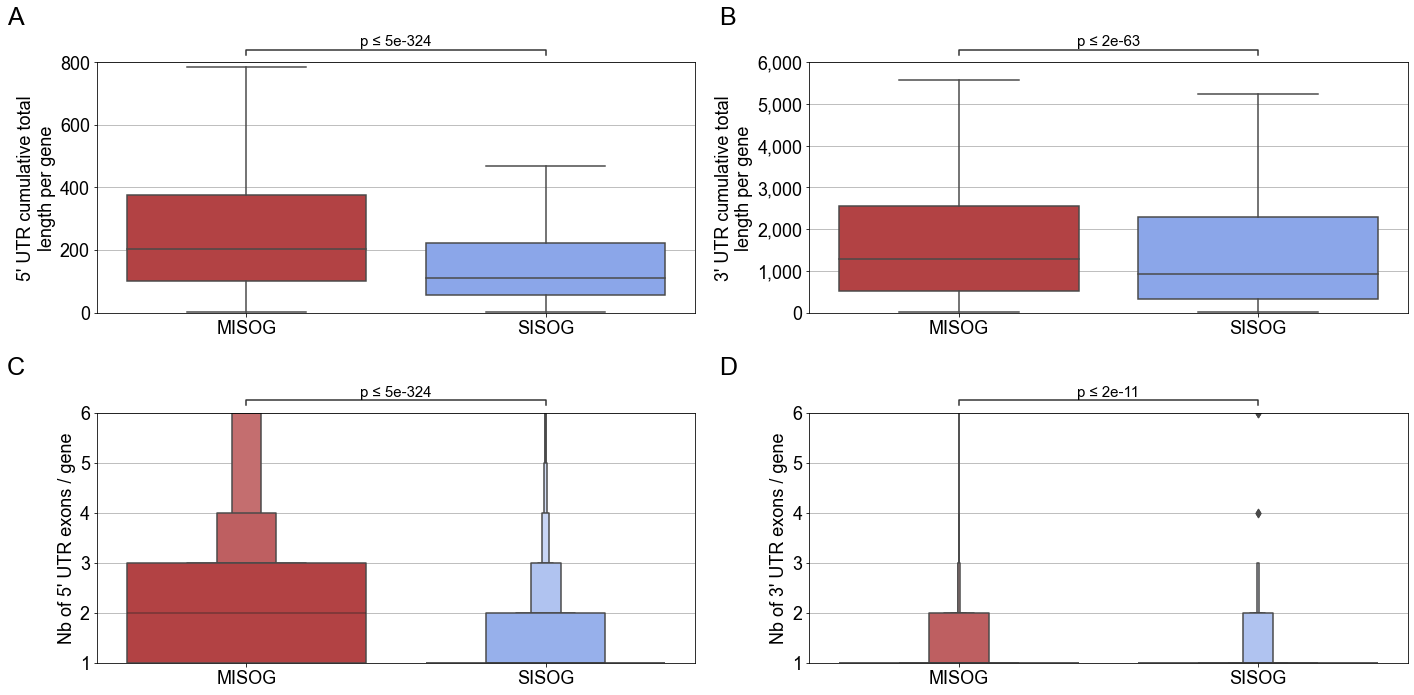

In [164]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            if np.isnan(p.get_height()) == False and p.get_height() > 0.4:
                value = '{:0}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center", fontsize=10) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

fig2 = plt.figure(figsize=(20, 10)) 
gs2 = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[1, 1]) 
ax10 = plt.subplot(gs[1,0])
ax11 = plt.subplot(gs[1,1])
ax20 = plt.subplot(gs[0,0])
ax21 = plt.subplot(gs[0,1])
# ax40 =  plt.subplot(gs[1,0])
# ax41 =  plt.subplot(gs[1,1])



data_5_prime = 100 * ( concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '5_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index().groupby('Miso_siso')['ranges'].value_counts() / concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '5_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index().groupby('Miso_siso')['ranges'].value_counts().groupby('Miso_siso').sum())
data_5_prime = data_5_prime.rename('count').reset_index()
data_5_prime = data_5_prime.loc[data_5_prime['ranges'] <= 7]
data_5_prime = data_5_prime.round()
data_3_prime = 100 * ( concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '3_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index().groupby('Miso_siso')['ranges'].value_counts() / concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '3_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index().groupby('Miso_siso')['ranges'].value_counts().groupby('Miso_siso').sum())
data_3_prime = data_3_prime.rename('count').reset_index()
data_3_prime = data_3_prime.loc[data_3_prime['ranges'] <= 7]
data_3_prime = data_3_prime.round()
data_length_utr = utrs.groupby(['Miso_siso', 'Gene', 'NM', 'UTR_bool'])['UTR_Length'].sum().sort_index().reset_index()


sns.boxenplot(data=concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '5_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index(), x='Miso_siso', y='ranges',  palette=palette, ax=ax10)
sns.boxenplot(data=concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '3_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index(), x='Miso_siso', y='ranges',  palette=palette, ax=ax11)
sns.boxplot(data=data_length_utr.loc[data_length_utr['UTR_bool'] == '5_prime'], x='Miso_siso', y='UTR_Length', showfliers=False, palette=palette, ax=ax20,
#            showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10}
           )
sns.boxplot(data=data_length_utr.loc[data_length_utr['UTR_bool'] == '3_prime'], x='Miso_siso', y='UTR_Length',  showfliers=False, palette=palette, ax=ax21,
#            showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10}
           )


# print(data_length_utr.loc[data_length_utr['UTR_bool'] == '5_prime'].groupby(['Miso_siso', 'variable'])['value'].describe())


# ax00.set_xlim(xmax=5.5)

ax01.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['MISOG', 'SISOG'])
# ax20.legend(loc='upper right', handles = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=10)], labels=['mean'], frameon=False, fontsize=12)
# ax00.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['M-iso', 'S-iso'])
# plt.legend(loc='upper center', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['M-iso', 'S-iso'])

ax10.set_xlabel("")
ax10.set_xticklabels(['MISOG', 'SISOG'])
ax10.set_ylabel("Nb of 5' UTR exons / gene")
ax11.set_ylabel("Nb of 3' UTR exons / gene")
ax11.set_xticklabels(['MISOG', 'SISOG'])
ax20.set_ylabel("5' UTR cumulative total\nlength per gene")
ax21.set_ylabel("3' UTR cumulative total\nlength per gene")
ax11.set_xlabel("")
ax20.set_xlabel("")
ax21.set_xlabel("")
ax20.set_xticklabels(['MISOG', 'SISOG'])
ax21.set_xticklabels(['MISOG', 'SISOG'])

# ax01.legend(title='', loc='upper right')
ax10.legend().remove()
ax11.legend().remove()
ax10.set_ylim(ymin=1, ymax=6)
ax11.set_ylim(ymin=1, ymax=6)
ax20.set_ylim(ymin=0, ymax=800)
ax21.set_ylim(ymin=0, ymax=0.6e4)

l_axes2 = [ax20, ax21, ax10, ax11,]

for sub_ax in l_axes2:
    sub_ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    

box_pairs = [((e, 'Miso'), (e, 'Siso')) for e in range(1,7)]

# add_stat_annotation(ax[0][0], data=data_5_prime.rename('count').reset_index(), x='ranges', y='count', hue='Miso_siso', fontsize=12,box_pairs=box_pairs, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff)
# add_stat_annotation(ax[0][1], data=data_3_prime.rename('count').reset_index(), x='ranges', y='count', hue='Miso_siso', fontsize=12,box_pairs=box_pairs, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff)
add_stat_annotation(ax10, data=concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '5_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index(), x='Miso_siso', y='ranges', fontsize=15,box_pairs=[('Miso', 'Siso')], test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff)
add_stat_annotation(ax11, data=concat_cds_exons.loc[concat_cds_exons['UTR_bool'] == '3_prime'].reset_index(drop=True).groupby(['Miso_siso', 'Gene', 'NM'])['ranges'].count().reset_index(), x='Miso_siso', y='ranges', fontsize=15,box_pairs=[('Miso', 'Siso')], test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff)
add_stat_annotation(ax20, data=data_length_utr.loc[data_length_utr['UTR_bool'] == '5_prime'], x='Miso_siso', y='UTR_Length', box_pairs=[('Miso', 'Siso')], test='Mann-Whitney', text_format='simple',fontsize=15, loc='outside', pvalue_thresholds=pvalues_cutoff)
add_stat_annotation(ax21, data=data_length_utr.loc[data_length_utr['UTR_bool'] == '3_prime'], x='Miso_siso', y='UTR_Length', box_pairs=[('Miso', 'Siso')], test='Mann-Whitney', text_format='simple',fontsize=15, loc='outside', pvalue_thresholds=pvalues_cutoff)


i = 0
for n, sub_a in enumerate(l_axes2):
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1


plt.tight_layout()
# data




for ax in l_axes2:
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    
plt.tight_layout()


figure_path2 = base_dir + yaml['Figures']['FigS2']
fig2.savefig(figure_path2, dpi=600)

# Raw values


In [177]:
concat_cds_exons_utr_length[['Gene', 'NM', 'Miso_siso', 'Complete_5_prime_UTR_length', 'Complete_3_prime_UTR_length']].drop_duplicates().melt(id_vars=['Gene', 'NM', 'Miso_siso',], value_vars=['Complete_5_prime_UTR_length', 'Complete_3_prime_UTR_length']).sort_values(by=['Miso_siso']).groupby(['variable', 'Miso_siso'])['value'].describe().to_excel('/gstock/GeneIso/results/tts_distance.xlsx')

In [127]:

data_length_utr.groupby(['Miso_siso', 'UTR_bool'])['UTR_Length'].describe().to_excel('/gstock/GeneIso/results/tts_distance.xlsx')


In [273]:
data_53_prime_concat = pd.concat(
    [
        data_5_prime.pivot(columns=['Miso_siso'], index='ranges', values='count'),
        data_3_prime.pivot(columns=['Miso_siso'], index='ranges', values='count'),
    ]
    ,axis=1
)
data_53_prime_concat = data_53_prime_concat.rename({'Miso' : 'M-iso', 'Siso' : 'S-iso'}, axis=1)
data_53_prime_concat.index.name = 'UTR exons number'
data_53_prime_concat.columns = pd.MultiIndex.from_product([["5'", "3'"], ['M-iso', 'S-iso']])
data_53_prime_concat

5'          3'      
                 M-iso S-iso M-iso S-iso
UTR exons number                        
1                41.00 75.00 93.00 96.00
2                34.00 21.00  6.00  4.00
3                13.00  3.00  0.00  0.00
4                 6.00  1.00  0.00  0.00
5                 3.00  0.00  0.00   nan
6                 1.00  0.00  0.00  0.00
7                 1.00  0.00  0.00   nan
8                 0.00  0.00  0.00   nan

# Fig S2

[(-1, -2), (-2, -3), (-3, -4), (-4, -5), (-1, -3), (-1, -4), (-1, -5)]
1 v.s. 2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.612e-36 U_stat=7.324e+07
2 v.s. 3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.672e-100 U_stat=1.442e+08
3 v.s. 4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.529e-57 U_stat=1.804e+08
4 v.s. 5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.687e-38 U_stat=1.807e+08
1 v.s. 3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.881e-202 U_stat=7.421e+07
1 v.s. 4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=6.892e+07
1 v.s. 5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=6.041e+07
-2 v.s. -1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=1.657e+08
-3 v.s. -2: Mann-Whitney-Wilcoxon test two-sided with Bonferr

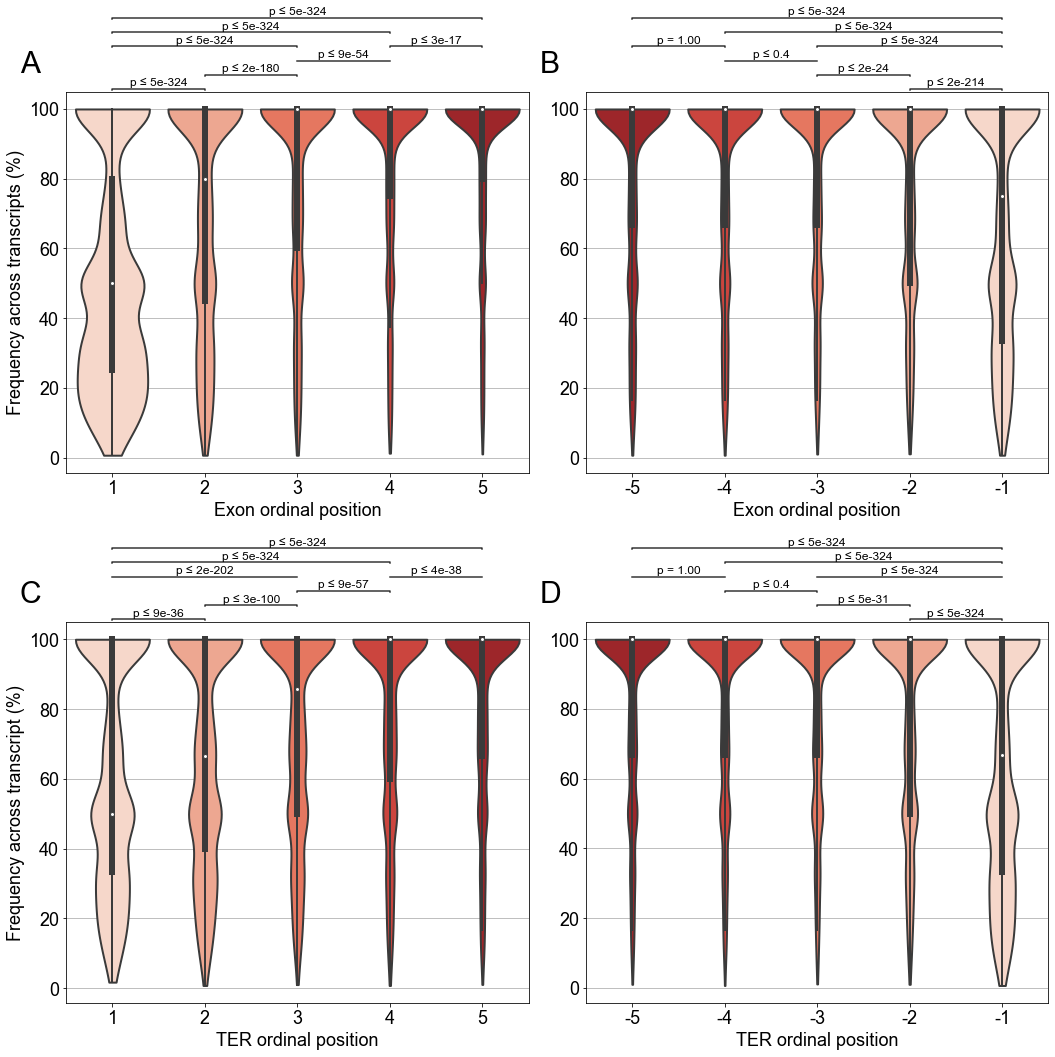

In [173]:
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

cds_freq = 100 * (refseq_cds.groupby('Gene')['ranges'].value_counts() / refseq_cds.groupby('Gene')['NM'].nunique())
cds_freq = cds_freq.rename('CDS_freq').reset_index()
cds_freq = pd.merge(concat_cds_exons.loc[concat_cds_exons['Type'] == 'CDS'], cds_freq, on=['Gene', 'ranges'])[['Miso_siso', 'Gene', 'Strand', 'ranges', 'Nb_exon_relative', 'CDS_freq']].drop_duplicates()
cds_freq = cds_freq.loc[cds_freq['Miso_siso'] == 'Miso']

cds_freq_inverted = 100 * (refseq_cds.groupby('Gene')['ranges'].value_counts() / refseq_cds.groupby('Gene')['NM'].nunique())
cds_freq_inverted = cds_freq_inverted.rename('CDS_freq').reset_index()
cds_freq_inverted = pd.merge(concat_cds_exons.loc[concat_cds_exons['Type'] == 'CDS'], cds_freq_inverted, on=['Gene', 'ranges'])[['Miso_siso', 'Gene', 'Strand', 'ranges', 'Nb_exon_inverted', 'CDS_freq']].drop_duplicates()
cds_freq_inverted = cds_freq_inverted.loc[cds_freq_inverted['Miso_siso'] == 'Miso']

exon_freq = 100 * (refseq_exons.groupby('Gene')['ranges'].value_counts() / refseq_exons.groupby('Gene')['NM'].nunique())
exon_freq = exon_freq.rename('Exon_freq').reset_index()
exon_freq = pd.merge(concat_cds_exons.loc[concat_cds_exons['Type'] == 'exon'], exon_freq, on=['Gene', 'ranges'])[['Miso_siso', 'Gene', 'Strand', 'ranges', 'Nb_exon', 'Exon_freq']].drop_duplicates()
exon_freq = exon_freq.loc[exon_freq['Miso_siso'] == 'Miso']

exon_freq_inverted = 100 * (refseq_exons.groupby('Gene')['ranges'].value_counts() / refseq_exons.groupby('Gene')['NM'].nunique())
exon_freq_inverted = exon_freq_inverted.rename('Exon_freq').reset_index()
exon_freq_inverted = pd.merge(concat_cds_exons.loc[concat_cds_exons['Type'] == 'exon'], exon_freq_inverted, on=['Gene', 'ranges'])[['Miso_siso', 'Gene', 'Strand', 'ranges', 'Nb_exon_inverted', 'Exon_freq']].drop_duplicates()
exon_freq_inverted = exon_freq_inverted.loc[exon_freq_inverted['Miso_siso'] == 'Miso']


cds_freq['Nb_exon_relative'] = cds_freq['Nb_exon_relative'].astype(int)
exon_freq['Nb_exon'] = exon_freq['Nb_exon'].astype(int)
cds_freq_inverted['Nb_exon_inverted'] = cds_freq_inverted['Nb_exon_inverted'].astype(int)
exon_freq_inverted['Nb_exon_inverted'] = exon_freq_inverted['Nb_exon_inverted'].astype(int)

k = 5
bw = 0.2
cut = 0
lw = 2
scale = "width"
line_height=0.002 
line_offset=0.005

lr = list(range(0,k))
box_pairs = [(e + 1, lr[i+1] + 1) for i, e in enumerate(lr) if i < len(lr) - 1]
box_pairs = box_pairs + [(1, lr[i+1] + 1) for i, e in enumerate(lr) if i < len(lr) - 1  and i > 0]
box_pairs_inverted = [(-1 * e[0], -1 * e[1]) for e in box_pairs]
print(box_pairs_inverted)

sns.violinplot(data=cds_freq.loc[(cds_freq['Nb_exon_relative'] <= k) & (cds_freq['Miso_siso'] == 'Miso')], x='Nb_exon_relative', y='CDS_freq', bw=bw, cut=cut,linewidth=lw,scale=scale,  showfliers=False, palette=sns.color_palette('Reds', k), ax=ax[1][0],
#            showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10}
             )

ax[1][0].set_ylabel('Frequency across transcript (%)')
ax[1][0].set_xlabel('TER ordinal position')
add_stat_annotation(ax[1][0], data=cds_freq.loc[(cds_freq['Nb_exon_relative'] <= k)], x='Nb_exon_relative', y='CDS_freq', fontsize=12, box_pairs=box_pairs, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff, line_height=line_height, line_offset=line_offset,)

sns.violinplot(data=cds_freq_inverted.loc[(cds_freq_inverted['Nb_exon_inverted'] >= -k) & (cds_freq_inverted['Miso_siso'] == 'Miso')], x='Nb_exon_inverted', y='CDS_freq', bw=bw, cut=cut, linewidth=lw,scale=scale, showfliers=False, palette=reversed(sns.color_palette('Reds', k)), ax=ax[1][1],
#            showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10}
             )
ax[1][1].set_ylabel('')
ax[1][1].set_xlabel('TER ordinal position')
add_stat_annotation(ax[1][1], data=cds_freq_inverted.loc[(cds_freq_inverted['Nb_exon_inverted'] >= -k)], x='Nb_exon_inverted', y='CDS_freq', fontsize=12, box_pairs=box_pairs_inverted, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff,  line_height=line_height, line_offset=line_offset)


sns.violinplot(data=exon_freq.loc[(exon_freq['Nb_exon'] <= k) & (exon_freq['Miso_siso'] == 'Miso')], x='Nb_exon', y='Exon_freq', showfliers=False, bw=bw, cut=cut, linewidth=lw,scale=scale, palette=sns.color_palette('Reds', k), ax=ax[0][0],
#            showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10}
             )
ax[0][0].set_ylabel('Frequency across transcripts (%)')
ax[0][0].set_xlabel('Exon ordinal position')
add_stat_annotation(ax[0][0], data=exon_freq.loc[(exon_freq['Nb_exon'] <= k)], x='Nb_exon', y='Exon_freq', fontsize=12, box_pairs=box_pairs, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff,  line_height=line_height, line_offset=line_offset)

sns.violinplot(data=exon_freq_inverted.loc[(exon_freq_inverted['Nb_exon_inverted'] >= -k) & (exon_freq_inverted['Miso_siso'] == 'Miso')], x='Nb_exon_inverted', y='Exon_freq', bw=bw, cut=cut, linewidth=lw,scale=scale, showfliers=False, palette=reversed(sns.color_palette('Reds', k)), ax=ax[0][1],
#            showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10}
             )
ax[0][1].set_ylabel('')
ax[0][1].set_xlabel('Exon ordinal position')
add_stat_annotation(ax[0][1], data=exon_freq_inverted.loc[(exon_freq_inverted['Nb_exon_inverted'] >= -k)], x='Nb_exon_inverted', y='Exon_freq', fontsize=12, box_pairs=box_pairs_inverted, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff,  line_height=line_height, line_offset=line_offset)


i = 0
for n, a in enumerate(ax):
    print(a)
    for sub_a in a:
#     print(sub_a)
        sub_a.grid(axis='y')
        sub_a.set_axisbelow(True)
        sub_a.text(-0.1, 1.05, string.ascii_uppercase[i], transform=sub_a.transAxes, size=30, weight='bold')
        i += 1


plt.tight_layout()

figure_path = base_dir + yaml['Figures']['FigS3']
f.savefig(figure_path, dpi=600)

# Raw values

In [200]:
concat_stats_freq = pd.concat(
    [
        cds_freq.loc[(cds_freq['Nb_exon_relative'] <= k) & (cds_freq['Miso_siso'] == 'Miso')].groupby(['Nb_exon_relative'])['CDS_freq'].describe(),
        exon_freq.loc[(exon_freq['Nb_exon'] <= k) & (exon_freq['Miso_siso'] == 'Miso')].groupby(['Nb_exon'])['Exon_freq'].describe(),
    ]
).T


concat_stats_freq.columns = pd.MultiIndex.from_product([["5'"],['TER', 'Exon'],list(range(1,k+1))])

concat_stats_freq

concat_stats_freq_inverted = pd.concat(
    [        
    cds_freq_inverted.loc[(cds_freq_inverted['Nb_exon_inverted'] >= -k) & (cds_freq_inverted['Miso_siso'] == 'Miso')].groupby(['Nb_exon_inverted'])['CDS_freq'].describe(),
    exon_freq_inverted.loc[(exon_freq_inverted['Nb_exon_inverted'] >= -k) & (exon_freq_inverted['Miso_siso'] == 'Miso')].groupby(['Nb_exon_inverted'])['Exon_freq'].describe(),
    ]
).T

concat_stats_freq_inverted

concat_stats_freq_inverted.columns = pd.MultiIndex.from_product([["3'"],['TER', 'Exon'],[-1 * e for e in reversed(list(range(1,k+1)))]])

concat_freq = pd.concat(
    [
        concat_stats_freq.T,
        concat_stats_freq_inverted.T
    ]
)

import openpyxl
workbook=openpyxl.load_workbook('/gstock/GeneIso/results/GeneIso.xlsx')
l_sheets = workbook.get_sheet_names()
if '4_Frequency' in l_sheets:
    std=workbook.get_sheet_by_name('4_Frequency')
    workbook.remove_sheet(std)

with pd.ExcelWriter('/gstock/GeneIso/results/GeneIso.xlsx', mode='a', engine='openpyxl') as writer:  
#     df.to_excel(writer, sheet_name='Sheet_name_3')
    concat_freq.to_excel(writer, sheet_name='4_Frequency')
concat_freq

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated function get_sheet_names (Use wb.sheetnames).


count       mean        std       min        25%         50%  \
5' TER   1   9613.0  61.940850  32.294472  1.724138  33.333333   50.000000   
         2  16803.0  67.318418  31.093720  0.763359  40.000000   66.666667   
         3  19594.0  74.368667  29.232412  1.030928  50.000000   85.714286   
         4  20158.0  79.008366  27.722661  0.763359  60.000000  100.000000   
         5  19263.0  82.533024  26.092841  1.063830  66.666667  100.000000   
         6  17830.0  84.863051  24.777447  0.694444  75.000000  100.000000   
   Exon  1  21599.0  51.046093  32.224178  0.694444  25.000000   50.000000   
         2  20035.0  70.443144  32.327964  0.694444  45.000000   80.000000   
         3  21089.0  79.525278  28.789316  0.694444  60.000000  100.000000   
         4  20820.0  83.916956  26.161232  1.282051  75.000000  100.000000   
         5  19662.0  86.200298  24.407032  1.063830  80.000000  100.000000   
         6  18130.0  87.332543  23.523443  0.694444  83.333333  100.000000   
3' TER  -6  13247.0  83.476456  25.739827  0.763359  66.666667  100.000000   
        -5  14370.0  83.628887  25.668341  1.030928  66.666667  100.000000   
        -4  15633.0  83.344846  25.848067  0.694444  66.666667  100.000000   
        -3  16270.0  82.826013  25.988507  1.136364  66.666667  100.000000   
        -2  16265.0  79.177056  27.946687  1.030928  50.000000  100.000000   
        -1  16612.0  65.089413  33.386746  0.694444  33.333333   66.666667   
   Exon -6  15646.0  81.619124  27.801092  0.763359  66.666667  100.000000   
        -5  16922.0  81.626635  27.753484  0.694444  66.666667  100.000000   
        -4  17764.0  81.776102  27.539236  0.694444  66.666667  100.000000   
        -3  17523.0  82.576159  26.677177  1.030928  66.666667  100.000000   
        -2  16403.0  79.364774  28.339940  1.098901  50.000000  100.000000   
        -1  16049.0  67.921823  32.961774  0.694444  33.333333   75.000000   

              75%    max  
5' TER   1  100.0  100.0  
         2  100.0  100.0  
         3  100.0  100.0  
         4  100.0  100.0  
         5  100.0  100.0  
         6  100.0  100.0  
   Exon  1   80.0  100.0  
         2  100.0  100.0  
         3  100.0  100.0  
         4  100.0  100.0  
         5  100.0  100.0  
         6  100.0  100.0  
3' TER  -6  100.0  100.0  
        -5  100.0  100.0  
        -4  100.0  100.0  
        -3  100.0  100.0  
        -2  100.0  100.0  
        -1  100.0  100.0  
   Exon -6  100.0  100.0  
        -5  100.0  100.0  
        -4  100.0  100.0  
        -3  100.0  100.0  
        -2  100.0  100.0  
        -1  100.0  100.0